# Import library

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
import torch.nn.functional as F
import torch.nn.init as init
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import pickle
import random
from os.path import dirname, join as pjoin
import copy
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('visualization.ipynb'), '../')))
from utils.networks import *
from utils.trainer import *
from utils.formulations import *

datafolderpath = '../data'
saveresultfolderpath = '../experiment/result'
figurefolderpath = './saved_figures/'

def report_savefig(plotname, resultfolderpath = './', formattype = 'pdf', pad_margin = 0.01):
    fig.savefig(resultfolderpath + plotname + f'.{formattype}',format=formattype, 
                bbox_inches='tight',pad_inches=pad_margin,transparent=True)
    
# def randomly_selected_date(df, random_seed = None):
#     # Create a copy of df_test_date
#     df = df.copy()
    
#     # Get unique dates
#     unique_dates = pd.Series(df_test_date.index.date).unique()
#     # Set the random seed for reproducibility (optional)
#     np.random.seed(random_seed)

#     # Define the time range and frequency
#     start_time = pd.to_datetime('06:45')
#     end_time = pd.to_datetime('17:00')
#     time_range = pd.date_range(start=start_time, end=end_time, freq='15T')

#     while True:
#         # Randomly select one date
#         random_date = np.random.choice(unique_dates)

#         # Filter the DataFrame for the selected date
#         mask = df.index.date == random_date
#         filtered_df = df[df.index.date == random_date]

#         # Randomly select one Site_id if there are multiple entries
#         if filtered_df['Site_id'].nunique() > 1:
#             selected_site_id = np.random.choice(filtered_df['Site_id'].unique())
#             # Update the mask to reflect the selection of a specific Site_id
#             mask = mask & (df['Site_id'] == selected_site_id).to_numpy()  # Combine the original mask with the Site_id filter
#             randomdate_df = filtered_df.loc[filtered_df['Site_id'] == selected_site_id]
#         else:
#             randomdate_df = filtered_df

#         # Check if the first datetime is 06:45 and if all required times are present
#         times_present = np.array([time in randomdate_df.index.time for time in time_range.time])

#         if (len(randomdate_df) > 0 and  # Check if randomdate_df is not empty
#             randomdate_df.index[0].time() == pd.to_datetime('06:45').time() and all(times_present)):
#             break  # Exit the loop if the condition is met
#     return randomdate_df, mask

def randomly_selected_date(df, num_dates=1, random_seed=None):
    # Create a copy of the DataFrame
    df = df.copy()

    # Get unique dates
    unique_dates = pd.Series(df.index.date).unique()

    # Set the random seed for reproducibility
    np.random.seed(random_seed)

    # Define the time range and frequency
    start_time = pd.to_datetime('06:45')
    end_time = pd.to_datetime('17:00')
    time_range = pd.date_range(start=start_time, end=end_time, freq='15T')

    selected_dates = []
    selected_dfs = []
    combined_mask = np.zeros(len(df), dtype=bool)  # Initialize combined mask

    while len(selected_dates) < num_dates:
        # Randomly select one date that hasn't been chosen yet
        random_date = np.random.choice(unique_dates)
        if random_date in selected_dates:
            continue  # Skip if the date has already been chosen

        # Filter the DataFrame for the selected date
        mask = df.index.date == random_date
        filtered_df = df[mask]

        # Randomly select one Site_id if there are multiple entries
        if filtered_df['Site_id'].nunique() > 1:
            selected_site_id = np.random.choice(filtered_df['Site_id'].unique())
            mask &= (df['Site_id'] == selected_site_id).to_numpy()
            filtered_df = filtered_df[filtered_df['Site_id'] == selected_site_id]

        # Check if all required times are present
        times_present = np.array([time in filtered_df.index.time for time in time_range.time])

        if (len(filtered_df) > 0 and  
            filtered_df.index[0].time() == pd.to_datetime('06:45').time() and all(times_present)):

            # Append to lists
            selected_dates.append(random_date)
            selected_dfs.append(filtered_df)
            combined_mask |= mask  # Update the combined mask

    # Concatenate all selected DataFrames into a single DataFrame
    random_dates_df = pd.concat(selected_dfs)

    return random_dates_df, combined_mask


# Import data

In [2]:
dict_path = os.path.join(datafolderpath, 'data_central_train_nonan.pkl')
with open(dict_path, 'rb') as pickle_file:
    data = pickle.load(pickle_file)
print(data.keys())

X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

target_col = data['target_col']
features_list = data['features_list']
future_regressor = data['future_regressor']

df_train_date = data['df_train_date']
df_val_daTe = data['df_val_date']
df_test_date = data['df_test_date']

num_step_ahead = data['num_step_ahead']
resolution = data['resolution']

df_test_features = data['df_test_nonan'] # For feature plotting

dict_keys(['X_train', 'y_train', 'X_val', 'y_val', 'X_test', 'y_test', 'target_col', 'features_list', 'future_regressor', 'df_train_nonan', 'df_val_nonan', 'df_test_nonan', 'df_train_date', 'df_val_date', 'df_test_date', 'timerange', 'num_step_ahead', 'resolution'])


# Import result

In [3]:
allresult_filename = ['sumk_solarcentral_4step_varylambda.pkl', 'sumk_lstm45_solarcentral_4step.pkl'
                      , 'qd_solarcentral_4step.pkl'
                      , 'cwcshri_solarcentral_4step.pkl', 'qr_solarcentral_4step.pkl']

index_path = next((i for i, s in enumerate(allresult_filename) if 'sumk_' in s), None)
dict_path = os.path.join(saveresultfolderpath, allresult_filename[index_path])
with open(dict_path, 'rb') as pickle_file:
    result_sumk_ann = pickle.load(pickle_file)
print(result_sumk_ann.keys())

index_path = next((i for i, s in enumerate(allresult_filename) if 'sumk_lstm45' in s), None)
dict_path = os.path.join(saveresultfolderpath, allresult_filename[index_path])
with open(dict_path, 'rb') as pickle_file:
    result_sumk_lstm = pickle.load(pickle_file)
#     result_sumk_lstm = torch.load(pickle_file, map_location=torch.device('cpu'))
print(result_sumk_lstm.keys())

index_path = next((i for i, s in enumerate(allresult_filename) if 'qd' in s), None)
dict_path = os.path.join(saveresultfolderpath, allresult_filename[index_path])
with open(dict_path, 'rb') as pickle_file:
    result_qd = pickle.load(pickle_file)
print(result_qd.keys()) 

index_path = next((i for i, s in enumerate(allresult_filename) if 'cwcshri' in s), None)
dict_path = os.path.join(saveresultfolderpath, allresult_filename[index_path])
with open(dict_path, 'rb') as pickle_file:
    result_cwcshri = pickle.load(pickle_file)
print(result_cwcshri.keys())

index_path = next((i for i, s in enumerate(allresult_filename) if 'qr' in s), None)
dict_path = os.path.join(saveresultfolderpath, allresult_filename[index_path])
with open(dict_path, 'rb') as pickle_file:
    result_qr = pickle.load(pickle_file)
print(result_qr.keys())

dict_path = os.path.join(saveresultfolderpath, 'point_solarcentral_4step.pkl')
with open(dict_path, 'rb') as pickle_file:
    result_point = pickle.load(pickle_file)
print(result_qr.keys())

## Define model and trainer
train = trainer_multistep(num_epochs = 2000, batch_size = 2000, patience = 200) #Set the trainer

dict_keys(['outputs_train', 'outputs_val', 'outputs_test', 'PICP_val', 'PICP_test', 'PINAW_test', 'PINALW_test', 'gamma', 'lambda'])
dict_keys(['outputs_train', 'outputs_val', 'outputs_test'])
dict_keys(['outputs_train', 'outputs_val', 'outputs_test', 'gamma'])
dict_keys(['outputs_train', 'outputs_val', 'outputs_test', 'gamma'])
dict_keys(['outputs_train', 'outputs_val', 'outputs_test'])


# Compare the loss

In [60]:
criterion = sumk_objective(delta_ = 0.1, gamma_ = 0.15, percentlargest_ = 0.3, lambda_ = 0.9
                                              , soften_ = 50, smoothfunction = 'tanh', returnseparatedloss = False)

upper_ann = torch.tensor(result_sumk_ann['outputs_val'][:,1::2,9])
lower_ann = torch.tensor(result_sumk_ann['outputs_val'][:,0::2,9])

upper_lstm = result_sumk_lstm['outputs_val'][:,1::2]
lower_lstm = result_sumk_lstm['outputs_val'][:,0::2]

print(f'The validation loss of ANN is {criterion(y_val, lower_ann, upper_ann).item():.4f}.')
print(f'The validation loss of LSTM is {criterion(y_val, lower_lstm, upper_lstm).item():.4f}.')

The validation loss of ANN is 0.1341.
The validation loss of LSTM is 0.1284.


# Performance index

## Calculate evaluation metrices

In [136]:
key = 'outputs_test'
ydata = y_test
ydata_range = y_train

formname = ['QR', 'QD', 'CWCshri', 'Sumk ANN', 'Sumk LSTM']
method_list = [result_qr[key], result_qd[key], result_cwcshri[key]
           , torch.tensor(result_sumk_ann[key][:,:,9]), result_sumk_lstm[key]]
picp_array = np.zeros((len(method_list), num_step_ahead))
pinaw_array = np.zeros((len(method_list), num_step_ahead))
pinalw_array = np.zeros((len(method_list), num_step_ahead))
winkler_array = np.zeros((len(method_list), num_step_ahead))

for i, method in enumerate(method_list):
    upper = method[:,1::2]
    lower = method[:,0::2]
    picp_array[i,:] = train.PICP(ydata, upper, lower)
    pinaw_array[i,:] = train.PINAW(upper, lower, ydata_range)
    pinalw_array[i,:] = train.PINALW(upper, lower, ydata_range, quantile = 0.5)
    winkler_array[i,:] = train.Winklerscore(upper, lower, ydata, ydata_range, delta = 0.1)
    
metric_list = [picp_array, pinaw_array, pinalw_array, winkler_array]
metrices_namelist = ['PICP', 'PINAW', 'PINALW', 'Winkler']

## Latex table

In [78]:
metric_list = [picp_array, pinaw_array, pinalw_array, winkler_array]
metrices_namelist = ['PICP', 'PINAW', 'PINALW', 'Winkler']

decimalplaces = 1

latextable = '\\begin{table} \n\\begin{tabular}'
column_count = len(metric_list) + 1
column_spec = "".join(["p{2.8cm}" for _ in range(column_count)])
latextable += f'{{{column_spec}}} \n\\hline \n'

for i in range(num_step_ahead):
    latextable += f'\hline\n\multicolumn{{{column_count}}}{{c}}{{{(i+1)*resolution}-minutes ahead}} \\\\ \n\hline\n\hline\n'

    latextable += 'Method '
    for eval_name in metrices_namelist:
        latextable += f' & {eval_name}'
        if 'ratio' in eval_name:
    latextable += '\\\\ \n\\hline\n'
    
    for j in range(len(method_list)):
        latextable += f'{formname[j]} '
        
        for metric in metric_list:
            nummetric = metric[j, i]
            latextable += f'& {nummetric:.{decimalplaces}f} '
        latextable += '\\\\ \n'
    latextable += '\hline\n'
    
latextable += '\\end{tabular} \n'
latextable += '\\end{table}'
print(latextable)

\begin{table} 
\begin{tabular}{p{2.8cm}p{2.8cm}p{2.8cm}p{2.8cm}p{2.8cm}} 
\hline 
\hline
\multicolumn{5}{c}{15-minutes ahead} \\ 
\hline
\hline
Method  & PINAW & Winkler & PINALW & Reduction ratio\\ 
\hline
QR & 353.5 & 432.4 & 570.9 & 0.3 \\ 
QD & 308.3 & 511.6 & 446.0 & 0.1 \\ 
CWCshri & 305.9 & 546.2 & 448.4 & 0.1 \\ 
Sumk ANN & 299.2 & 586.8 & 401.8 & 0.0 \\ 
Sumk LSTM & 303.9 & 603.6 & 395.4 & 0.0 \\ 
\hline
\hline
\multicolumn{5}{c}{30-minutes ahead} \\ 
\hline
\hline
Method  & PINAW & Winkler & PINALW & Reduction ratio\\ 
\hline
QR & 346.5 & 489.3 & 548.7 & 0.2 \\ 
QD & 356.4 & 560.9 & 500.9 & 0.1 \\ 
CWCshri & 352.2 & 578.5 & 497.3 & 0.1 \\ 
Sumk ANN & 357.1 & 621.0 & 468.1 & 0.0 \\ 
Sumk LSTM & 337.3 & 595.5 & 445.0 & 0.0 \\ 
\hline
\hline
\multicolumn{5}{c}{45-minutes ahead} \\ 
\hline
\hline
Method  & PINAW & Winkler & PINALW & Reduction ratio\\ 
\hline
QR & 401.4 & 508.7 & 608.6 & 0.2 \\ 
QD & 409.9 & 575.6 & 574.4 & 0.2 \\ 
CWCshri & 408.5 & 575.0 & 584.4 & 0.2 \\ 
Sumk AN

## Latex table for reduction ratio

In [139]:
formname = ['QR', 'QD', '$\\text{CWC}_{\\text{Shri}}$', 'Sum-$k$ ANN', 'Sum-$k$ LSTM']
pinalw_reduction_ratio_array = 1 - (pinalw_array[-1,:]/pinalw_array)
metric_list = [pinaw_array, winkler_array, pinalw_array, pinalw_reduction_ratio_array]
metrices_namelist = ['PINAW', 'Winkler', 'PINALW', 'Reduction ratio']

decimalplaces = 3

latextable = '\\begin{table} \n\\begin{tabular}'
column_count = len(metric_list) + 1
column_spec = "".join(["p{2.8cm}" for _ in range(column_count)])
latextable += f'{{{column_spec}}} \n\\hline \n'

for i in range(num_step_ahead):
    latextable += f'\hline\n\multicolumn{{{column_count}}}{{c}}{{{(i+1)*resolution}-minutes ahead}} \\\\ \n\hline\n\hline\n'

    latextable += 'Method '
    for eval_name in metrices_namelist:
        latextable += f' & {eval_name}'
    latextable += '\\\\ \n\\hline\n'
    
    for j in range(len(method_list)):
#         print(i, j)
        latextable += f'{formname[j]} '
        for k, metric in enumerate(metric_list):
            nummetric = metric[j, i]
            if k == len(metric_list)-1:
                latextable += '& {:.1f}\\% '.format(nummetric * 100)
            else:
                latextable += f'& {nummetric:.{decimalplaces}f} '
        latextable += '\\\\ \n'
    latextable += '\hline\n'
    
latextable += '\\end{tabular} \n'
latextable += '\\end{table}'
print(latextable)

\begin{table} 
\begin{tabular}{p{2.8cm}p{2.8cm}p{2.8cm}p{2.8cm}p{2.8cm}} 
\hline 
\hline
\multicolumn{5}{c}{15-minutes ahead} \\ 
\hline
\hline
Method  & PINAW & Winkler & PINALW & Reduction ratio\\ 
\hline
QR & 0.395 & 0.484 & 0.638 & 30.7\% \\ 
QD & 0.345 & 0.572 & 0.499 & 11.3\% \\ 
$\text{CWC}_{\text{Shri}}$ & 0.342 & 0.611 & 0.501 & 11.8\% \\ 
Sum-$k$ ANN & 0.335 & 0.656 & 0.449 & 1.6\% \\ 
Sum-$k$ LSTM & 0.340 & 0.675 & 0.442 & 0.0\% \\ 
\hline
\hline
\multicolumn{5}{c}{30-minutes ahead} \\ 
\hline
\hline
Method  & PINAW & Winkler & PINALW & Reduction ratio\\ 
\hline
QR & 0.388 & 0.547 & 0.614 & 18.9\% \\ 
QD & 0.399 & 0.627 & 0.560 & 11.2\% \\ 
$\text{CWC}_{\text{Shri}}$ & 0.394 & 0.647 & 0.556 & 10.5\% \\ 
Sum-$k$ ANN & 0.399 & 0.694 & 0.523 & 4.9\% \\ 
Sum-$k$ LSTM & 0.377 & 0.666 & 0.498 & 0.0\% \\ 
\hline
\hline
\multicolumn{5}{c}{45-minutes ahead} \\ 
\hline
\hline
Method  & PINAW & Winkler & PINALW & Reduction ratio\\ 
\hline
QR & 0.449 & 0.569 & 0.681 & 20.9\% \\ 
QD & 0.

# Bar graph

In [5]:
key = 'outputs_test'
ydata = y_test
ydata_range = None

method_list = [result_qr[key], result_qd[key], result_cwcshri[key]
           , torch.tensor(result_sumk_ann[key][:,:,9]), result_sumk_lstm[key]]

formname = ['QR', 'QD', 'CWCshri', 'Sumk ANN', 'Sumk LSTM']
metrices_namelist = ['PICP', 'PINAW ($\wm$)', 'PINALW ($\wm$)', 'Winkler ($\wm$)']

picp_array = np.zeros((len(method_list), num_step_ahead))
pinaw_array = np.zeros((len(method_list), num_step_ahead))
pinalw_array = np.zeros((len(method_list), num_step_ahead))
winkler_array = np.zeros((len(method_list), num_step_ahead))

for i, method in enumerate(method_list):
    upper = method[:,1::2]
    lower = method[:,0::2]
    picp_array[i,:] = train.PICP(ydata, upper, lower)
    pinaw_array[i,:] = train.PINAW(upper, lower, ydata_range)
    pinalw_array[i,:] = train.PINALW(upper, lower, ydata_range, quantile = 0.5)
    winkler_array[i,:] = train.Winklerscore(upper, lower, ydata, ydata_range, delta = 0.1)
    
metric_list = [picp_array, pinaw_array, pinalw_array, winkler_array]

## Full version

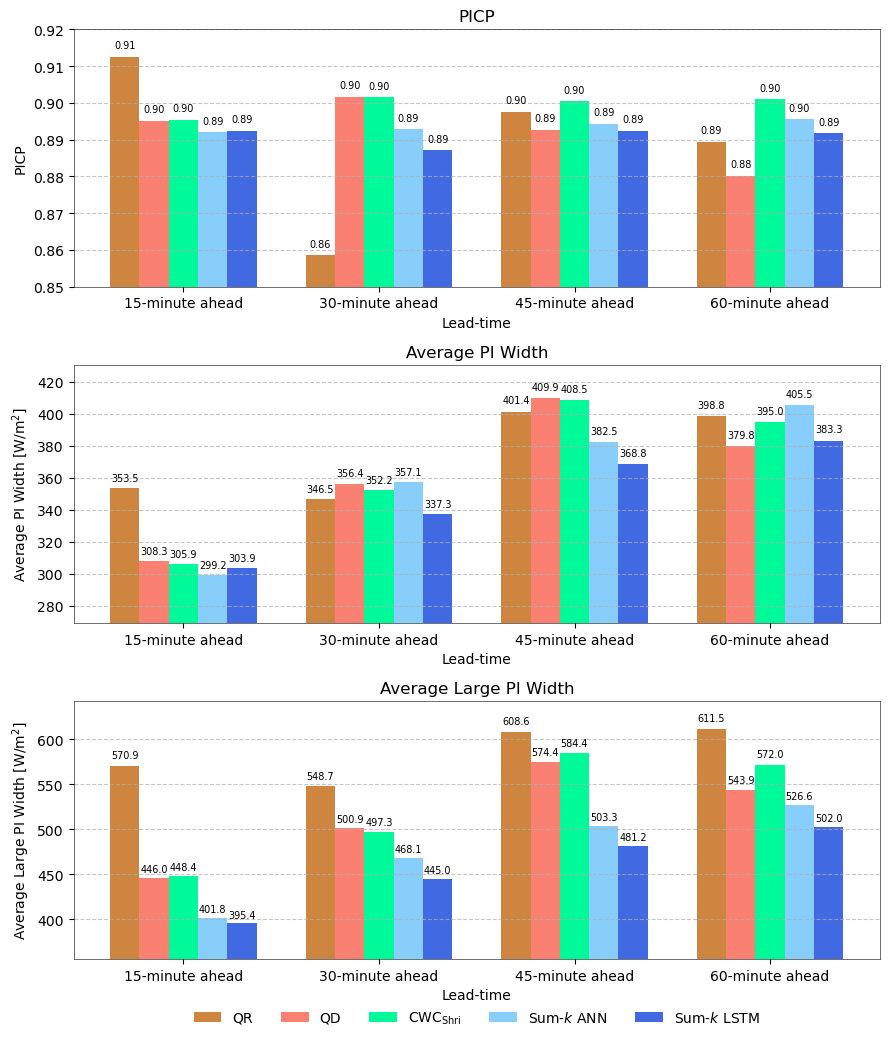

In [33]:
formname = ['QR', 'QD', r'$\text{CWC}_{\text{Shri}}$', 'Sum-$k$ ANN', 'Sum-$k$ LSTM']
horizons = ['15-minute ahead', '30-minute ahead', '45-minute ahead', '60-minute ahead']
width_plot_list = [picp_array, pinaw_array, pinalw_array]

fig, ax = plt.subplots(nrows = len(width_plot_list), figsize=(9, 3.5*len(width_plot_list)))
colors = ['peru', 'salmon', 'mediumspringgreen', 'lightskyblue', 'royalblue']
title_name = ['PICP', 'Average PI Width', 'Average Large PI Width']
ylabel_name = ['PICP', r'Average PI Width $[\text{W/m}^{2}]$', r'Average Large PI Width $[\text{W/m}^{2}]$']

for k, width_plot in enumerate(width_plot_list):
    # Parameters for bar plot
    num_horizons = width_plot.shape[1]  # Now this represents groups
    num_methods = width_plot.shape[0]   # Each horizon contains bars for different methods
    bar_width = 0.15
    indices = np.arange(num_horizons)
    offsets = [i * bar_width for i in range(num_methods)]

    for i, (method, offset) in enumerate(zip(formname, offsets)):
        ax[k].bar(indices + offset, width_plot[i], bar_width, label=method, color=colors[i])

        # Adding the numbers above each bar
        for j in range(num_horizons):
            if k == 0:
                ax[k].text(j + offset, width_plot[i, j]*1.002, f'{width_plot[i, j]:.2f}', ha='center', va='bottom'
                        , fontsize = 7)
                ax[k].set_ylim([0.85, 0.92])
            else:
                ax[k].text(j + offset, width_plot[i, j]*1.01, f'{width_plot[i, j]:.1f}', ha='center', va='bottom'
                        , fontsize = 7)
                ax[k].set_ylim([width_plot.min()*0.9, width_plot.max()*1.05])

    ax[k].grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
    # Labels and formatting
    ax[k].set_xlabel('Lead-time')
    ax[k].set_ylabel(f'{ylabel_name[k]}')
    ax[k].set_title(f'{title_name[k]}')
    ax[k].set_xticks(indices + bar_width * (num_methods - 1) / 2)
    ax[k].set_xticklabels(horizons)
    # ax.legend(loc = 'upper left', fontsize = 8)
    if k == len(width_plot_list)-1:
        ax[k].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=num_methods, fontsize=10, frameon = False)
        
for axis in ax:
    for spine in axis.spines.values():
        spine.set_linewidth(0.4)

plt.tight_layout()
plt.show()
report_savefig('bar_solar_performance_comparison', resultfolderpath = figurefolderpath)

## Small version

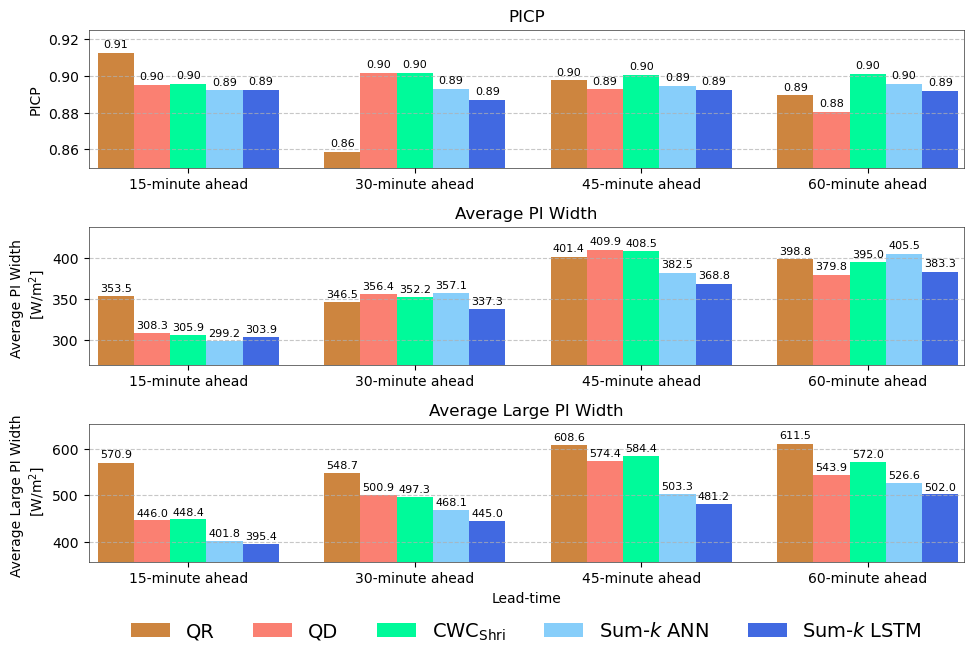

In [13]:
formname = ['QR', 'QD', r'$\text{CWC}_{\text{Shri}}$', 'Sum-$k$ ANN', 'Sum-$k$ LSTM']
horizons = ['15-minute ahead', '30-minute ahead', '45-minute ahead', '60-minute ahead']
width_plot_list = [picp_array, pinaw_array, pinalw_array]

fig, ax = plt.subplots(nrows = len(width_plot_list), figsize=(10, 2.25*len(width_plot_list)))
colors = ['peru', 'salmon', 'mediumspringgreen', 'lightskyblue', 'royalblue']
title_name = ['PICP', 'Average PI Width', 'Average Large PI Width']
ylabel_name = ['PICP', 'Average PI Width \n [W/m$^2$]', 'Average Large PI Width \n [W/m$^2$]']

ep = 0.01

for k, width_plot in enumerate(width_plot_list):
    # Parameters for bar plot
    num_horizons = width_plot.shape[1]  # Now this represents groups
    num_methods = width_plot.shape[0]   # Each horizon contains bars for different methods
    bar_width = 0.12
    indices = np.arange(num_horizons)*0.75
    offsets = [i * bar_width for i in range(num_methods)]

    for i, (method, offset) in enumerate(zip(formname, offsets)):
        ax[k].bar(indices + offset, width_plot[i], bar_width, label=method, color=colors[i])
        # Adding the numbers above each bar
        for j in range(num_horizons):
            if k == 0:
                ax[k].text(indices[j] + offset, width_plot[i, j]*1.002, f'{width_plot[i, j]:.2f}', ha='center', va='bottom'
                        , fontsize = 8)
                ax[k].set_ylim([0.85, 0.925])
            else:
                ax[k].text(indices[j] + offset, width_plot[i, j]*1.01, f'{width_plot[i, j]:.1f}', ha='center', va='bottom'
                        , fontsize = 8)
                ax[k].set_ylim([width_plot.min()*0.9, width_plot.max()*1.07])

    ax[k].grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
    # Labels and formatting
    if k == len(width_plot_list)-1:
        ax[k].set_xlabel('Lead-time')
    ax[k].set_ylabel(f'{ylabel_name[k]}')
#     ax[k].set_ylabel('Average PI Width \n W/m$^2$')
    ax[k].set_title(f'{title_name[k]}')
    ax[k].set_xticks(indices + bar_width * (num_methods - 1) / 2)
    ax[k].set_xticklabels(horizons)
    ax[k].set_xlim([-0.1+ep,2.82-ep])
#     ax[k].set_xlim(indices[0] - 0.2, indices[-1] + 0.2)
    # ax.legend(loc = 'upper left', fontsize = 8)
    if k == len(width_plot_list)-1:
        ax[k].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=num_methods, fontsize=14, frameon = False)
        
for axis in ax:
    for spine in axis.spines.values():
        spine.set_linewidth(0.4)

plt.tight_layout()
plt.show()
# report_savefig('bar_solar_performance_comparison_compressed', resultfolderpath = figurefolderpath)

## Smaller for IEEE:Sustain

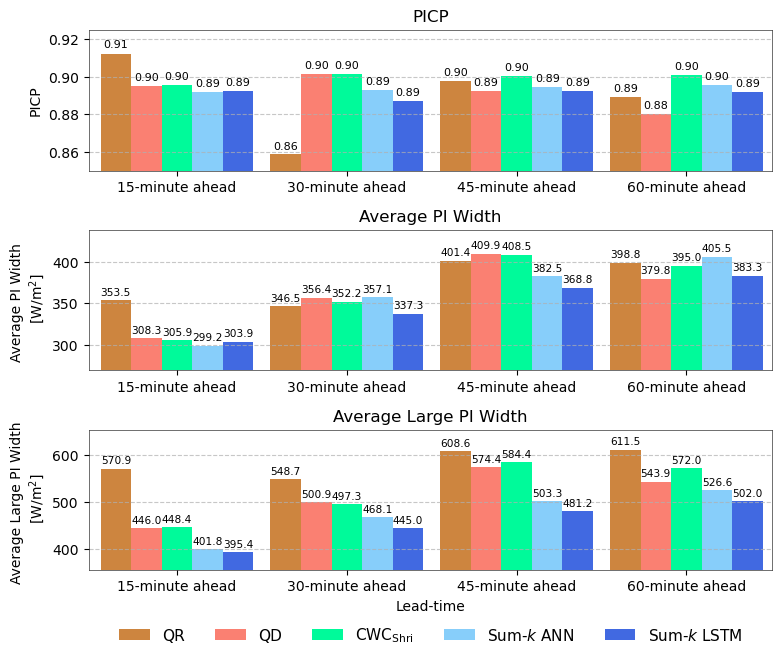

In [28]:
formname = ['QR', 'QD', r'$\text{CWC}_{\text{Shri}}$', 'Sum-$k$ ANN', 'Sum-$k$ LSTM']
horizons = ['15-minute ahead', '30-minute ahead', '45-minute ahead', '60-minute ahead']
width_plot_list = [picp_array, pinaw_array, pinalw_array]

fig, ax = plt.subplots(nrows = len(width_plot_list), figsize=(8, 2.25*len(width_plot_list)))
colors = ['peru', 'salmon', 'mediumspringgreen', 'lightskyblue', 'royalblue']
title_name = ['PICP', 'Average PI Width', 'Average Large PI Width']
ylabel_name = ['PICP', 'Average PI Width \n [W/m$^2$]', 'Average Large PI Width \n [W/m$^2$]']

ep = -0.02

for k, width_plot in enumerate(width_plot_list):
    # Parameters for bar plot
    num_horizons = width_plot.shape[1]  # Now this represents groups
    num_methods = width_plot.shape[0]   # Each horizon contains bars for different methods
    bar_width = 0.135
    indices = np.arange(num_horizons)*0.75
    offsets = [i * bar_width for i in range(num_methods)]

    for i, (method, offset) in enumerate(zip(formname, offsets)):
        ax[k].bar(indices + offset, width_plot[i], bar_width, label=method, color=colors[i])
        # Adding the numbers above each bar
        for j in range(num_horizons):
            if k == 0:
                ax[k].text(indices[j] + offset, width_plot[i, j]*1.002, f'{width_plot[i, j]:.2f}', ha='center', va='bottom'
                        , fontsize = 8)
                ax[k].set_ylim([0.85, 0.925])
            else:
                ax[k].text(indices[j] + offset, width_plot[i, j]*1.01, f'{width_plot[i, j]:.1f}', ha='center', va='bottom'
                        , fontsize = 7.6)
                ax[k].set_ylim([width_plot.min()*0.9, width_plot.max()*1.07])

    ax[k].grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
    # Labels and formatting
    if k == len(width_plot_list)-1:
        ax[k].set_xlabel('Lead-time')
    ax[k].set_ylabel(f'{ylabel_name[k]}')
#     ax[k].set_ylabel('Average PI Width \n W/m$^2$')
    ax[k].set_title(f'{title_name[k]}')
    ax[k].set_xticks(indices + bar_width * (num_methods - 1) / 2)
    ax[k].set_xticklabels(horizons)
#     ax[k].set_xlim([-0.1+ep,2.82-ep])
    ax[k].set_xlim([-0.1 + ep, 2.88 - ep])
#     ax[k].set_xlim(indices[0] - 0.2, indices[-1] + 0.2)
    # ax.legend(loc = 'upper left', fontsize = 8)
    if k == len(width_plot_list)-1:
        ax[k].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=num_methods, fontsize=11, frameon = False)
        
for axis in ax:
    for spine in axis.spines.values():
        spine.set_linewidth(0.4)

plt.tight_layout()
plt.show()
# report_savefig('bar_solar_performance_comparison_onecol', resultfolderpath = figurefolderpath)

# Feature plotting

In [160]:
df_features = df_test_features[['I', 'Iclr', 'Inwp', 'CI_R']]

## CI_R vs k

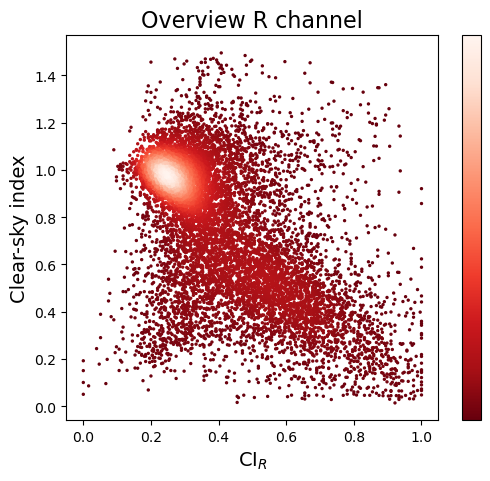

In [185]:
df_features.loc[:, 'k'] = df_features['I']/(df_features['Iclr'] + 1e-3)
df_plot = df_features[(df_features['k'] < 1.5) & (df_features['k'] > 1e-3)]

X = df_plot['CI_R']
Y = df_plot['k']

xy = np.vstack([X,Y])
z = gaussian_kde(xy)(xy)

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 5))

# Density plot with scatter
sc = ax.scatter(x = X, y = Y, c = z, s=2, cmap = 'Reds_r', alpha=1)
# Colorbar
cbar = fig.colorbar(sc)
cbar.set_ticks([])

# Labels & Title
ax.set_xlabel(r"CI$_R$", fontsize=14)
ax.set_ylabel("Clear-sky index", fontsize=14)
ax.set_title("Overview R channel", fontsize=16)

# Show plot
plt.show()

# report_savefig('scatter_k_cir', resultfolderpath = figurefolderpath)

## Time series of clear-sky irradiance and Inwp

[datetime.date(2023, 2, 14) datetime.date(2023, 3, 10)
 datetime.date(2023, 6, 7) datetime.date(2023, 11, 16)]
['clearsky' 'cloudy' 'partlycloudy']


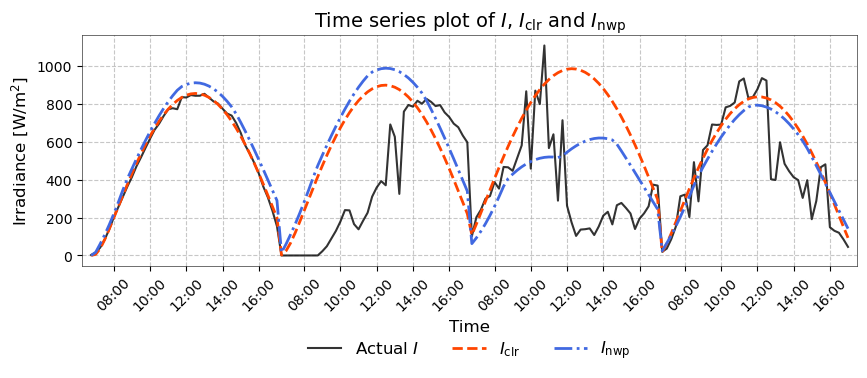

In [322]:
randomdate_df, mask_date = randomly_selected_date(df_test_date, num_dates = 4, random_seed = 2)

print(np.unique(randomdate_df.index.date))
print(df_test_date[mask_date]['skycondition'].unique())

df_time_plot = df_features[mask_date]
iclr_data = df_time_plot['Iclr'].to_numpy()
inwp_data = df_time_plot['Inwp'].to_numpy()
i_data = df_time_plot['I'].to_numpy()

fig, ax = plt.subplots(figsize = (10, 3))

# Define the times you want to show (you can leave the dates out for this variable)
desired_times = ['08:00', '10:00', '12:00', '14:00', '16:00']
# Get the time values from the DataFrame index
time_values = df_time_plot.index
# Create a list of positions for the desired times
xtick_positions = [index for index, t in enumerate(time_values) if t.strftime('%H:%M') in desired_times]
# Create formatted labels that include the date and time
xtick_labels = [t.strftime('%H:%M') for t in time_values if t.strftime('%H:%M') in desired_times]

ax.plot(i_data, label = 'Actual $I$'
        , linestyle = '-', color = 'black', alpha = 0.8, linewidth = 1.5)
ax.plot(iclr_data, label = r'$I_{\text{clr}}$'
        , linestyle = 'dashed', color = 'orangered', linewidth = 2)
ax.plot(inwp_data, label = r'$I_{\text{nwp}}$'
        , linestyle = 'dashdot', color = 'royalblue', linewidth = 2)

ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, rotation=45)
ax.grid(linestyle='--', alpha=0.7)

ax.set_title(r'Time series plot of $I$, $I_{\text{clr}}$ and $I_{\text{nwp}}$', fontsize = 14)
ax.set_ylabel(r'Irradiance $[\text{W/m}^{2}]$', fontsize = 12)
ax.set_xlabel('Time', fontsize = 12)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=  3, fontsize=12, frameon = False)
ax.set_xlim([-2, 169])

# Reduce the border line thickness
for spine in ax.spines.values():
    spine.set_linewidth(0.4) 

plt.show()

# report_savefig('timeseries_features', resultfolderpath = figurefolderpath)

In [ ]:
# fig, ax = plt.subplots(nrows=4, figsize=((4/3)*7, (4/3)*7))
fig, ax = plt.subplots(nrows=4, figsize=((4/3)*8, (4/3)*7))
plt.subplots_adjust(hspace=0.2)


y_plot_condition = y_plot[condition]
pi_ref = pi_plots[-1]

# Define the times you want to show (you can leave the dates out for this variable)
desired_times = ['08:00', '10:00', '12:00', '14:00', '16:00']
# Get the time values from the DataFrame index
time_values = df_forindex[condition].index
# Create a list of positions for the desired times
xtick_positions = [index for index, t in enumerate(time_values) if t.strftime('%H:%M') in desired_times]
# Create formatted labels that include the date and time
xtick_labels = [t.strftime('%H:%M') for t in time_values if t.strftime('%H:%M') in desired_times]

legend_handles = []
legend_labels = [r'Actual $I$'] + formname_list

for i, (pi, color, formname) in enumerate(zip(pi_plots, color_list, formname_list)):
    if i == len(pi_plots) - 1:  # Skip the last index
        break
    actual_plot, = ax[i].plot(y_plot_condition, color='black', label=r'Actual $I$',
           marker='.', linestyle='', markersize=4, alpha=0.5)
    if i == 0:
        legend_handles.append(actual_plot)
    pi_condition = pi[condition, 2 * (stepahead - 1):2 * stepahead]
    upper_plot = pi_condition[:, 1]
    lower_plot = pi_condition[:, 0]
    ax[i].plot(upper_plot, color=color, linestyle = 'dashed')
    ax[i].plot(lower_plot, color=color, linestyle = 'dashed')
    pi_benchmarked_plot = ax[i].fill_between(range(len(upper_plot)), lower_plot, upper_plot, color = color, 
                      alpha = 0.2, label = f'{formname}')
    legend_handles.append(pi_benchmarked_plot)
    
    pi_ref_condition = pi_ref[condition, 2 * (stepahead - 1):2 * stepahead]
    color_ref = color_list[-1]
    formname_ref = formname_list[-1]
    upper_plot_ref = pi_ref_condition[:, 1]
    lower_plot_ref = pi_ref_condition[:, 0]
    ax[i].plot(upper_plot_ref, color=color_ref, linestyle = 'dashed')
    ax[i].plot(lower_plot_ref, color=color_ref, linestyle = 'dashed')
    pi_ref_plot = ax[i].fill_between(range(len(upper_plot_ref)), lower_plot_ref, upper_plot_ref, color = color_ref, 
                      alpha = 0.2, label = f'{formname_ref}')
    
    if i == len(pi_plots) - 2:
        legend_handles.append(pi_ref_plot)

    # Set x-ticks and x-tick labels
    if i == len(pi_plots)-2:
        ax[i].set_xticks(xtick_positions)
        ax[i].set_xticklabels(xtick_labels, rotation=45)
        ax[i].set_xlabel('Time')
    else:
        ax[i].set_xticks(xtick_positions)  # Retain the ticks (dashes)
        ax[i].set_xticklabels([]) 

    ax[i].set_xlim([-2, 169])
    ax[i].set_ylim([0, 1350])
    ax[i].set_ylabel(r'Irradiance $[\text{W/m}^{2}]$')
    ax[i].set_title(f'{formname} vs Sum-$k$ LSTM')

#     if i == len(pi_plots)-2:
#         ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=  6, fontsize=10, frameon = False)

    text_list = []
    xcoor_fortext = [0.13, 0.38, 0.63, 0.88]
    for k in range(4):
        date_text = df_forindex.loc[condition, 'Date'].iloc[k*len(y_plot_condition)//4 + len(y_plot_condition)//8].strftime('%d-%m-%Y')
        site_text = df_forindex.loc[condition, 'Site_id'].iloc[k*len(y_plot_condition)//4 + len(y_plot_condition)//8]
        text_add = f'Date: {date_text}, Site id: {site_text}'
        text_list.append(text_add)

        ax[i].text(xcoor_fortext[k], 0.9, text_add, ha='center', va='bottom', 
                   transform=ax[i].transAxes, fontsize=8)

    # Reduce the border line thickness
    for spine in ax[i].spines.values():
        spine.set_linewidth(0.4)

# Add single legend at the bottom without duplicates
fig.legend(legend_handles, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 0.04), 
           ncol=6, fontsize=10, frameon=False)

fig.suptitle('Clear-sky Condition', fontsize=16, fontweight='bold', fontstyle='italic', y = 0.94, x = 0.515)
    
# plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
# report_savefig('piplot_clearsky_comparison_worstqdcondwithlstm_onecol', resultfolderpath = figurefolderpath)

# Timeseries plot of 15-minute ahead PIs

## Groupping data

In [14]:
df = df_test_date.copy()
lamb_index = 9
outputs_test_sumk_plot = torch.tensor(result_sumk_ann['outputs_test'][:,:,lamb_index])
upper_sumk = outputs_test_sumk_plot[:,1::2]
lower_sumk = outputs_test_sumk_plot[:,0::2]
width_sumk = upper_sumk - lower_sumk
df['width_sumk_ahead15'] = width_sumk[:,0]

upper_qd = result_qd['outputs_test'][:,1::2]
lower_qd = result_qd['outputs_test'][:,0::2]
width_qd = upper_qd - lower_qd
df['width_qd_ahead15'] = width_qd[:,0]

upper_sumk_lstm = result_sumk_lstm['outputs_test'][:,1::2]
lower_sumk_lstm = result_sumk_lstm['outputs_test'][:,0::2]
width_sumk_lstm = upper_sumk_lstm - lower_sumk_lstm
df['width_sumk_lstm_ahead15'] = width_sumk_lstm[:,0]

df['Date'] = df.index.date
time_range = pd.date_range(start='06:45', end='17:00', freq='15T').time
df['counttimeslot'] = df.groupby(['Site_id', 'Date']).transform('count')['width_sumk_ahead15']
# Extract only full timeslot in the date
df = df[df['counttimeslot'] == len(time_range)] 

grouped_df = df.groupby(['Site_id', 'skycondition', 'Date', 'counttimeslot']).agg(
    avg_width_sumk_ahead15=('width_sumk_ahead15', 'mean'),
    avg_width_qd_ahead15=('width_qd_ahead15', 'mean'),
    avg_width_sumk_lstm_ahead15=('width_sumk_lstm_ahead15', 'mean')
).reset_index()

grouped_df['deviation'] = grouped_df['avg_width_qd_ahead15'] - grouped_df['avg_width_sumk_ahead15']
grouped_df['model_deviation'] = grouped_df['avg_width_sumk_ahead15'] - grouped_df['avg_width_sumk_lstm_ahead15']

# List of sky conditions to iterate over
sky_conditions = ['clearsky', 'partlycloudy', 'cloudy']

## Compare between Sum-k and QD

avg_width_qd_ahead15


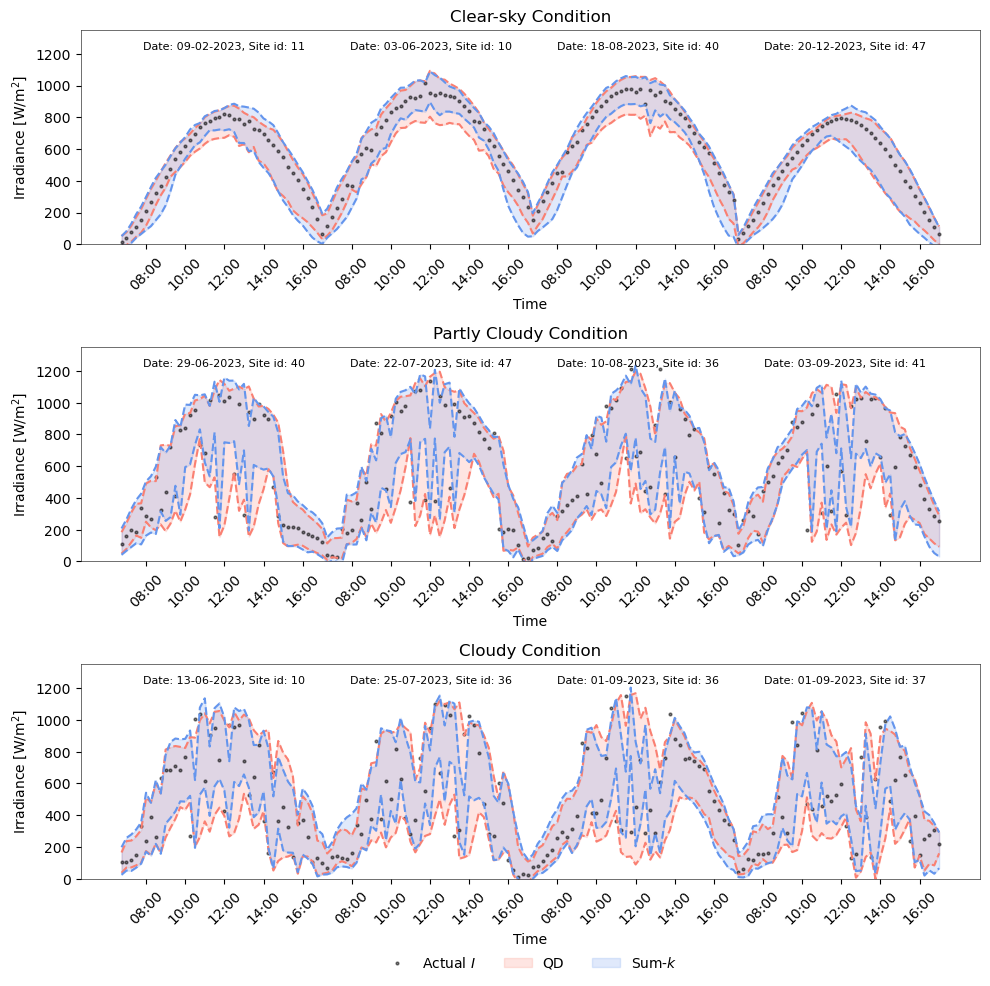

In [56]:
numcond = 1 # for compare QD and Sumk
# List to store the top 5 deviations for each sky condition
top_list = []

filtered_cond = ['deviation', 'avg_width_qd_ahead15', 'avg_width_sumk_ahead15'
               , 'model_deviation', 'avg_width_sumk_lstm_ahead15', 'avg_width_sumk_ahead15']
print(filtered_cond[numcond])
# Calculate top 5 deviations for each sky condition
for condition in sky_conditions:
    # Filter the grouped DataFrame for the specific sky condition
    filtered_df = grouped_df[grouped_df['skycondition'] == condition]
    
    top_deviation = filtered_df.nlargest(4, filtered_cond[numcond])
#     top_deviation = filtered_df.nsmallest(4, filtered_cond[numcond])
    
    # Add rank within each sky condition
    top_deviation['rank'] = top_deviation[filtered_cond[numcond]].rank(method='first', ascending=False).astype(int)
    
    # Append to the list
    top_list.append(top_deviation)

# Concatenate all top 5 DataFrames into a single DataFrame
top_deviation_combined = pd.concat(top_list, ignore_index=True)

# Define the specific Site_ids and corresponding dates
cloudcond_key_list = ['clearsky', 'partlycloudy', 'cloudy']
allconditions = []
for cloudcond in cloudcond_key_list:
    site_list = top_deviation_combined[top_deviation_combined['skycondition']==cloudcond]['Site_id'].to_numpy()
    date_list = top_deviation_combined[top_deviation_combined['skycondition']==cloudcond]['Date'].to_numpy()
    conditions = []
    for i in range(len(site_list)):
        cond = (df_test_date['Site_id'] == site_list[i]) & (df_test_date.index.date == date_list[i])
        conditions.append(cond)
    conditions = np.logical_or.reduce(conditions)
    allconditions.append(conditions)

# Define the plot characteristics
stepahead = 1
y_plot = y_test[:, stepahead - 1]
# conditions = [conditions_clearsky, conditions_partlycloudy, conditions_cloudy]
condname_list = ['Clear-sky', 'Partly Cloudy', 'Cloudy']
df_forindex = df_test_date.copy()
df_forindex['Date'] = df_forindex.index.date

# PI to plot
pi_plots = [result_qd['outputs_test'], torch.tensor(result_sumk_ann['outputs_test'][:, :, 9])]
color_list = ['salmon', 'cornflowerblue']
formname_list = ['QD', 'Sum-$k$']

fig, ax = plt.subplots(nrows=3, figsize=(10, 10))

# Define the times you want to show (you can leave the dates out for this variable)
desired_times = ['08:00', '10:00', '12:00', '14:00', '16:00']

for i, condition in enumerate(allconditions):
    y_plot_condition = y_plot[condition]
    ax[i].plot(y_plot_condition, color='black', label=r'Actual $I$',
               marker='.', linestyle='', markersize=4, alpha=0.5)
    for pi, color, formname in zip(pi_plots, color_list, formname_list):
        pi_condition = pi[condition, 2 * (stepahead - 1):2 * stepahead]
        upper_plot = pi_condition[:, 1]
        lower_plot = pi_condition[:, 0]
        ax[i].plot(upper_plot, color=color, linestyle = 'dashed')
        ax[i].plot(lower_plot, color=color, linestyle = 'dashed')
        ax[i].fill_between(range(len(upper_plot)), lower_plot, upper_plot, color = color, 
                          alpha = 0.2, label = f'{formname}')

    # Get the time values from the DataFrame index
    time_values = df_forindex[condition].index

    # Create a list of positions for the desired times
    xtick_positions = [index for index, t in enumerate(time_values) if t.strftime('%H:%M') in desired_times]
    # Create formatted labels that include the date and time
    xtick_labels = [t.strftime('%H:%M') for t in time_values if t.strftime('%H:%M') in desired_times]

    # Set x-ticks and x-tick labels
    ax[i].set_xticks(xtick_positions)
    ax[i].set_xticklabels(xtick_labels, rotation=45)
    ax[i].set_ylim([0, 1350])
    ax[i].set_ylabel(r'Irradiance $[\text{W/m}^{2}]$')
    ax[i].set_xlabel('Time')
    ax[i].set_title(f'{condname_list[i]} Condition')
    
    if i == len(allconditions)-1:
        ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=  3, fontsize=10, frameon = False)
    
    text_list = []
    xcoor_fortext = [0.16, 0.39, 0.62, 0.85]
    for k in range(4):
        date_text = df_forindex.loc[condition, 'Date'].iloc[k*len(y_plot_condition)//4 + len(y_plot_condition)//8].strftime('%d-%m-%Y')
        site_text = df_forindex.loc[condition, 'Site_id'].iloc[k*len(y_plot_condition)//4 + len(y_plot_condition)//8]
        text_add = f'Date: {date_text}, Site id: {site_text}'
        text_list.append(text_add)
        
        ax[i].text(xcoor_fortext[k], 0.9, text_add, ha='center', va='bottom', 
                   transform=ax[i].transAxes, fontsize=8)
    
    # Reduce the border line thickness
    for spine in ax[i].spines.values():
        spine.set_linewidth(0.4)
    
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
report_savefig('piplot_sepsky_solar_comparison_worstqdcond', resultfolderpath = figurefolderpath)

In [ ]:
numcond = 1 # for compare QD and Sumk
# List to store the top 5 deviations for each sky condition
top_list = []

filtered_cond = ['deviation', 'avg_width_qd_ahead15', 'avg_width_sumk_ahead15'
               , 'model_deviation', 'avg_width_sumk_lstm_ahead15', 'avg_width_sumk_ahead15']
print(filtered_cond[numcond])
# Calculate top 5 deviations for each sky condition
for condition in sky_conditions:
    # Filter the grouped DataFrame for the specific sky condition
    filtered_df = grouped_df[grouped_df['skycondition'] == condition]
    
    top_deviation = filtered_df.nlargest(4, filtered_cond[numcond])
#     top_deviation = filtered_df.nsmallest(4, filtered_cond[numcond])
    
    # Add rank within each sky condition
    top_deviation['rank'] = top_deviation[filtered_cond[numcond]].rank(method='first', ascending=False).astype(int)
    
    # Append to the list
    top_list.append(top_deviation)

# Concatenate all top 5 DataFrames into a single DataFrame
top_deviation_combined = pd.concat(top_list, ignore_index=True)

# Define the specific Site_ids and corresponding dates
cloudcond_key_list = ['clearsky', 'partlycloudy', 'cloudy']
allconditions = []
for cloudcond in cloudcond_key_list:
    site_list = top_deviation_combined[top_deviation_combined['skycondition']==cloudcond]['Site_id'].to_numpy()
    date_list = top_deviation_combined[top_deviation_combined['skycondition']==cloudcond]['Date'].to_numpy()
    conditions = []
    for i in range(len(site_list)):
        cond = (df_test_date['Site_id'] == site_list[i]) & (df_test_date.index.date == date_list[i])
        conditions.append(cond)
    conditions = np.logical_or.reduce(conditions)
    allconditions.append(conditions)

# Define the plot characteristics
stepahead = 1
y_plot = y_test[:, stepahead - 1]
# conditions = [conditions_clearsky, conditions_partlycloudy, conditions_cloudy]
condname_list = ['Clear-sky', 'Partly Cloudy', 'Cloudy']
df_forindex = df_test_date.copy()
df_forindex['Date'] = df_forindex.index.date

# PI to plot
pi_plots = [result_qd['outputs_test'], torch.tensor(result_sumk_ann['outputs_test'][:, :, 9])]
color_list = ['salmon', 'cornflowerblue']
formname_list = ['QD', 'Sum-$k$']

fig, ax = plt.subplots(nrows=3, figsize=(10, 10))

# Define the times you want to show (you can leave the dates out for this variable)
desired_times = ['08:00', '10:00', '12:00', '14:00', '16:00']

for i, condition in enumerate(allconditions):
    y_plot_condition = y_plot[condition]
    ax[i].plot(y_plot_condition, color='black', label=r'Actual $I$',
               marker='.', linestyle='', markersize=4, alpha=0.5)
    for pi, color, formname in zip(pi_plots, color_list, formname_list):
        pi_condition = pi[condition, 2 * (stepahead - 1):2 * stepahead]
        upper_plot = pi_condition[:, 1]
        lower_plot = pi_condition[:, 0]
        ax[i].plot(upper_plot, color=color, linestyle = 'dashed')
        ax[i].plot(lower_plot, color=color, linestyle = 'dashed')
        ax[i].fill_between(range(len(upper_plot)), lower_plot, upper_plot, color = color, 
                          alpha = 0.2, label = f'{formname}')

    # Get the time values from the DataFrame index
    time_values = df_forindex[condition].index

    # Create a list of positions for the desired times
    xtick_positions = [index for index, t in enumerate(time_values) if t.strftime('%H:%M') in desired_times]
    # Create formatted labels that include the date and time
    xtick_labels = [t.strftime('%H:%M') for t in time_values if t.strftime('%H:%M') in desired_times]

    # Set x-ticks and x-tick labels
    ax[i].set_xticks(xtick_positions)
    ax[i].set_xticklabels(xtick_labels, rotation=45)
    ax[i].set_ylim([0, 1350])
    ax[i].set_ylabel(r'Irradiance $[\text{W/m}^{2}]$')
    ax[i].set_xlabel('Time')
    ax[i].set_title(f'{condname_list[i]} Condition')
    
    if i == len(allconditions)-1:
        ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=  3, fontsize=10, frameon = False)
    
    text_list = []
    xcoor_fortext = [0.16, 0.39, 0.62, 0.85]
    for k in range(4):
        date_text = df_forindex.loc[condition, 'Date'].iloc[k*len(y_plot_condition)//4 + len(y_plot_condition)//8].strftime('%d-%m-%Y')
        site_text = df_forindex.loc[condition, 'Site_id'].iloc[k*len(y_plot_condition)//4 + len(y_plot_condition)//8]
        text_add = f'Date: {date_text}, Site id: {site_text}'
        text_list.append(text_add)
        
        ax[i].text(xcoor_fortext[k], 0.9, text_add, ha='center', va='bottom', 
                   transform=ax[i].transAxes, fontsize=8)
    
    # Reduce the border line thickness
    for spine in ax[i].spines.values():
        spine.set_linewidth(0.4)
    
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
report_savefig('piplot_sepsky_solar_comparison_worstqdcond', resultfolderpath = figurefolderpath)

## Compare between Sum-k ANN and Sum-k LSTM

avg_width_sumk_ahead15


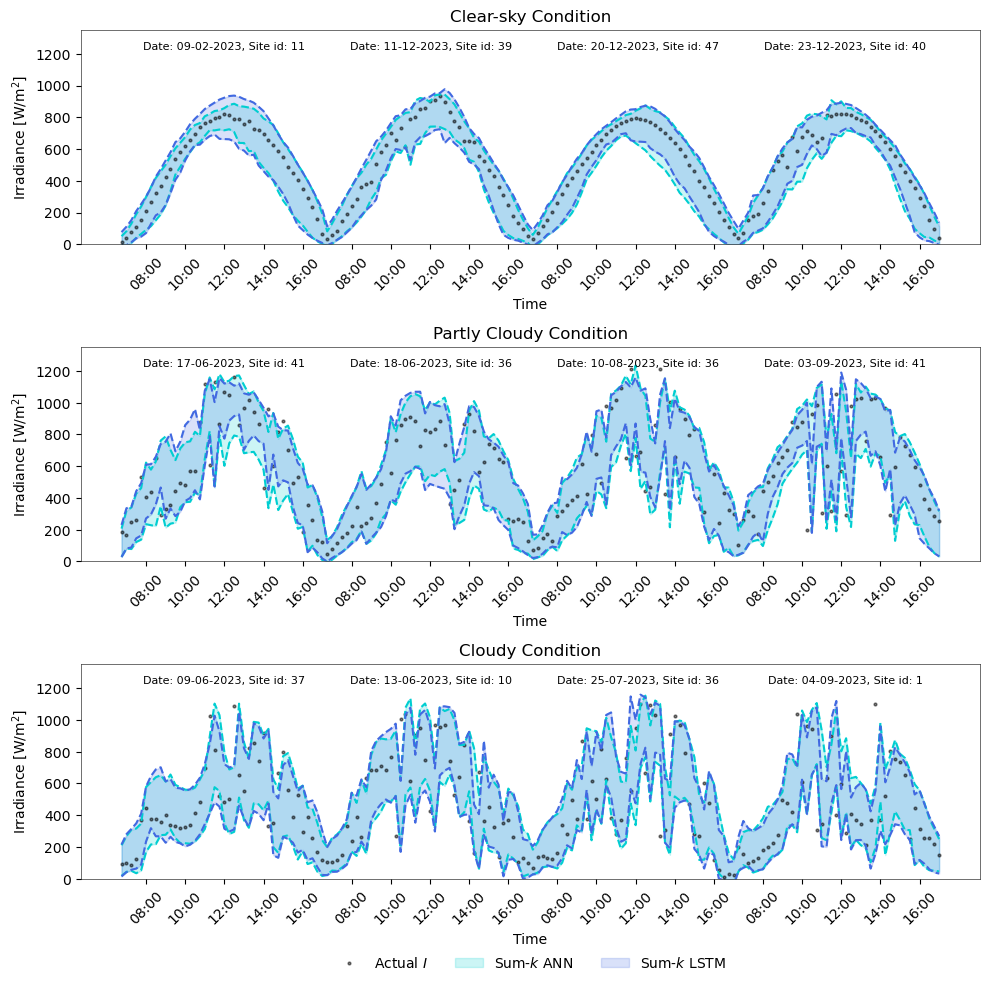

In [55]:
numcond = -1 # for compare ANN and LSTM
# List to store the top 5 deviations for each sky condition
top_list = []

filtered_cond = ['deviation', 'avg_width_qd_ahead15', 'avg_width_sumk_ahead15'
               , 'model_deviation', 'avg_width_sumk_lstm_ahead15', 'avg_width_sumk_ahead15']
print(filtered_cond[numcond])
# Calculate top 5 deviations for each sky condition
for condition in sky_conditions:
    # Filter the grouped DataFrame for the specific sky condition
    filtered_df = grouped_df[grouped_df['skycondition'] == condition]
    
    top_deviation = filtered_df.nlargest(4, filtered_cond[numcond])
#     top_deviation = filtered_df.nsmallest(4, filtered_cond[numcond])
    
    # Add rank within each sky condition
    top_deviation['rank'] = top_deviation[filtered_cond[numcond]].rank(method='first', ascending=False).astype(int)
    
    # Append to the list
    top_list.append(top_deviation)

# Concatenate all top 5 DataFrames into a single DataFrame
top_deviation_combined = pd.concat(top_list, ignore_index=True)

# Define the specific Site_ids and corresponding dates
cloudcond_key_list = ['clearsky', 'partlycloudy', 'cloudy']
allconditions = []
for cloudcond in cloudcond_key_list:
    site_list = top_deviation_combined[top_deviation_combined['skycondition']==cloudcond]['Site_id'].to_numpy()
    date_list = top_deviation_combined[top_deviation_combined['skycondition']==cloudcond]['Date'].to_numpy()
    conditions = []
    for i in range(len(site_list)):
        cond = (df_test_date['Site_id'] == site_list[i]) & (df_test_date.index.date == date_list[i])
        conditions.append(cond)
    conditions = np.logical_or.reduce(conditions)
    allconditions.append(conditions)

# Define the plot characteristics
stepahead = 1
y_plot = y_test[:, stepahead - 1]
# conditions = [conditions_clearsky, conditions_partlycloudy, conditions_cloudy]
condname_list = ['Clear-sky', 'Partly Cloudy', 'Cloudy']
df_forindex = df_test_date.copy()
df_forindex['Date'] = df_forindex.index.date

# PI to plot
pi_plots = [torch.tensor(result_sumk_ann['outputs_test'][:, :, 9]), result_sumk_lstm['outputs_test']]
color_list = ['darkturquoise', 'royalblue']
formname_list = ['Sum-$k$ ANN', 'Sum-$k$ LSTM']

fig, ax = plt.subplots(nrows=3, figsize=(10, 10))

# Define the times you want to show (you can leave the dates out for this variable)
desired_times = ['08:00', '10:00', '12:00', '14:00', '16:00']

for i, condition in enumerate(allconditions):
    y_plot_condition = y_plot[condition]
    ax[i].plot(y_plot_condition, color='black', label=r'Actual $I$',
               marker='.', linestyle='', markersize=4, alpha=0.5)
    for pi, color, formname in zip(pi_plots, color_list, formname_list):
        pi_condition = pi[condition, 2 * (stepahead - 1):2 * stepahead]
        upper_plot = pi_condition[:, 1]
        lower_plot = pi_condition[:, 0]
        ax[i].plot(upper_plot, color=color, linestyle = 'dashed')
        ax[i].plot(lower_plot, color=color, linestyle = 'dashed')
        ax[i].fill_between(range(len(upper_plot)), lower_plot, upper_plot, color = color, 
                          alpha = 0.2, label = f'{formname}')

    # Get the time values from the DataFrame index
    time_values = df_forindex[condition].index

    # Create a list of positions for the desired times
    xtick_positions = [index for index, t in enumerate(time_values) if t.strftime('%H:%M') in desired_times]
    # Create formatted labels that include the date and time
    xtick_labels = [t.strftime('%H:%M') for t in time_values if t.strftime('%H:%M') in desired_times]

    # Set x-ticks and x-tick labels
    ax[i].set_xticks(xtick_positions)
    ax[i].set_xticklabels(xtick_labels, rotation=45)
    ax[i].set_ylim([0, 1350])
    ax[i].set_ylabel(r'Irradiance $[\text{W/m}^{2}]$')
    ax[i].set_xlabel('Time')
    ax[i].set_title(f'{condname_list[i]} Condition')
    
    if i == len(allconditions)-1:
        ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=  3, fontsize=10, frameon = False)
    
    text_list = []
    xcoor_fortext = [0.16, 0.39, 0.62, 0.85]
    for k in range(4):
        date_text = df_forindex.loc[condition, 'Date'].iloc[k*len(y_plot_condition)//4 + len(y_plot_condition)//8].strftime('%d-%m-%Y')
        site_text = df_forindex.loc[condition, 'Site_id'].iloc[k*len(y_plot_condition)//4 + len(y_plot_condition)//8]
        text_add = f'Date: {date_text}, Site id: {site_text}'
        text_list.append(text_add)
        
        ax[i].text(xcoor_fortext[k], 0.9, text_add, ha='center', va='bottom', 
                   transform=ax[i].transAxes, fontsize=8)
    
    # Reduce the border line thickness
    for spine in ax[i].spines.values():
        spine.set_linewidth(0.4)
    
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

report_savefig('piplot_sepsky_solar_comparison_worstsumkanncond', resultfolderpath = figurefolderpath)

## Aggregated version

avg_width_qd_ahead15


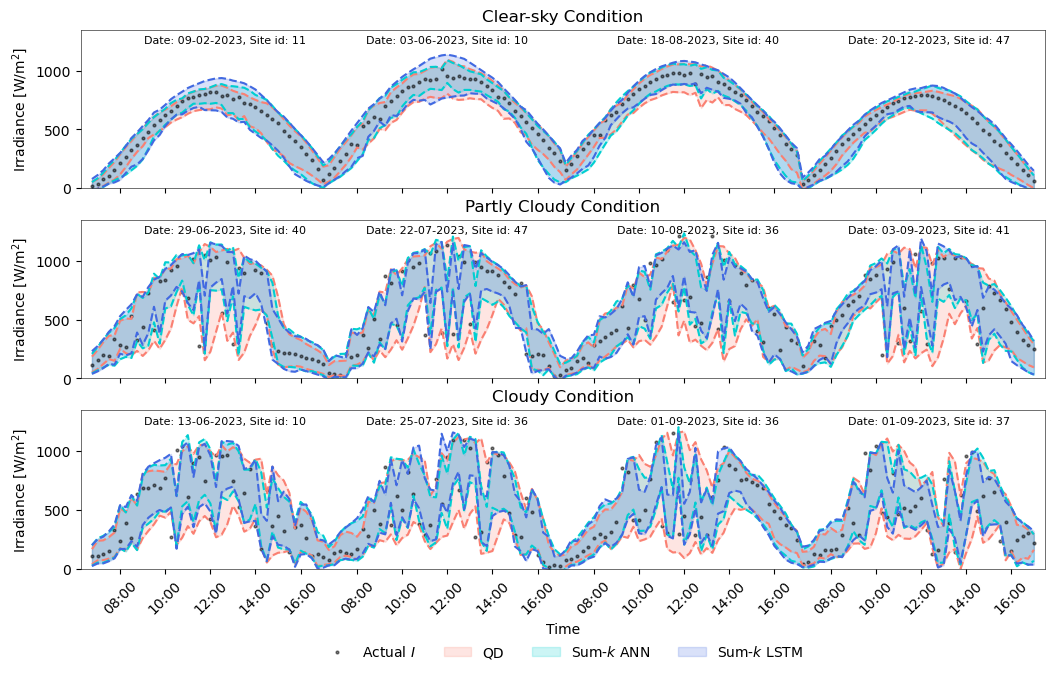

In [20]:
numcond = 1 # for compare QD and Sumk
# List to store the top 5 deviations for each sky condition
top_list = []

filtered_cond = ['deviation', 'avg_width_qd_ahead15', 'avg_width_sumk_ahead15'
               , 'model_deviation', 'avg_width_sumk_lstm_ahead15', 'avg_width_sumk_ahead15']
print(filtered_cond[numcond])
# Calculate top 5 deviations for each sky condition
for condition in sky_conditions:
    # Filter the grouped DataFrame for the specific sky condition
    filtered_df = grouped_df[grouped_df['skycondition'] == condition]
    
    top_deviation = filtered_df.nlargest(4, filtered_cond[numcond])
#     top_deviation = filtered_df.nsmallest(4, filtered_cond[numcond])
    # Add rank within each sky condition
    top_deviation['rank'] = top_deviation[filtered_cond[numcond]].rank(method='first', ascending=False).astype(int)
    
    # Append to the list
    top_list.append(top_deviation)

# Concatenate all top 5 DataFrames into a single DataFrame
top_deviation_combined = pd.concat(top_list, ignore_index=True)

# Define the specific Site_ids and corresponding dates
cloudcond_key_list = ['clearsky', 'partlycloudy', 'cloudy']
allconditions = []
for cloudcond in cloudcond_key_list:
    site_list = top_deviation_combined[top_deviation_combined['skycondition']==cloudcond]['Site_id'].to_numpy()
    date_list = top_deviation_combined[top_deviation_combined['skycondition']==cloudcond]['Date'].to_numpy()
    conditions = []
    for i in range(len(site_list)):
        cond = (df_test_date['Site_id'] == site_list[i]) & (df_test_date.index.date == date_list[i])
        conditions.append(cond)
    conditions = np.logical_or.reduce(conditions)
    allconditions.append(conditions)

# Define the plot characteristics
stepahead = 1
y_plot = y_test[:, stepahead - 1]
# conditions = [conditions_clearsky, conditions_partlycloudy, conditions_cloudy]
condname_list = ['Clear-sky', 'Partly Cloudy', 'Cloudy']
df_forindex = df_test_date.copy()
df_forindex['Date'] = df_forindex.index.date

# PI to plot
pi_plots = [result_qd['outputs_test'], torch.tensor(result_sumk_ann['outputs_test'][:, :, 9]), result_sumk_lstm['outputs_test']]
color_list = ['salmon', 'darkturquoise', 'royalblue']
formname_list = ['QD', 'Sum-$k$ ANN', 'Sum-$k$ LSTM']

fig, ax = plt.subplots(nrows=3, figsize=((16/9)*7, 1*7))
plt.subplots_adjust(hspace=0.2)

# Define the times you want to show (you can leave the dates out for this variable)
desired_times = ['08:00', '10:00', '12:00', '14:00', '16:00']

for i, condition in enumerate(allconditions):
    y_plot_condition = y_plot[condition]
    ax[i].plot(y_plot_condition, color='black', label=r'Actual $I$',
               marker='.', linestyle='', markersize=4, alpha=0.5)
    for pi, color, formname in zip(pi_plots, color_list, formname_list):
        pi_condition = pi[condition, 2 * (stepahead - 1):2 * stepahead]
        upper_plot = pi_condition[:, 1]
        lower_plot = pi_condition[:, 0]
        ax[i].plot(upper_plot, color=color, linestyle = 'dashed')
        ax[i].plot(lower_plot, color=color, linestyle = 'dashed')
        ax[i].fill_between(range(len(upper_plot)), lower_plot, upper_plot, color = color, 
                          alpha = 0.2, label = f'{formname}')

    # Get the time values from the DataFrame index
    time_values = df_forindex[condition].index

    # Create a list of positions for the desired times
    xtick_positions = [index for index, t in enumerate(time_values) if t.strftime('%H:%M') in desired_times]
    # Create formatted labels that include the date and time
    xtick_labels = [t.strftime('%H:%M') for t in time_values if t.strftime('%H:%M') in desired_times]

    # Set x-ticks and x-tick labels
    if i == len(allconditions)-1:
        ax[i].set_xticks(xtick_positions)
        ax[i].set_xticklabels(xtick_labels, rotation=45)
        ax[i].set_xlabel('Time')
    else:
        ax[i].set_xticks(xtick_positions)  # Retain the ticks (dashes)
        ax[i].set_xticklabels([]) 
        
    ax[i].set_xlim([-2, 169])
    ax[i].set_ylim([0, 1350])
    ax[i].set_ylabel(r'Irradiance $[\text{W/m}^{2}]$')
    ax[i].set_title(f'{condname_list[i]} Condition')
    
    if i == len(allconditions)-1:
        ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=  4, fontsize=10, frameon = False)
    
    text_list = []
    xcoor_fortext = [0.15, 0.38, 0.64, 0.88]
    for k in range(4):
        date_text = df_forindex.loc[condition, 'Date'].iloc[k*len(y_plot_condition)//4 + len(y_plot_condition)//8].strftime('%d-%m-%Y')
        site_text = df_forindex.loc[condition, 'Site_id'].iloc[k*len(y_plot_condition)//4 + len(y_plot_condition)//8]
        text_add = f'Date: {date_text}, Site id: {site_text}'
        text_list.append(text_add)
        
        ax[i].text(xcoor_fortext[k], 0.9, text_add, ha='center', va='bottom', 
                   transform=ax[i].transAxes, fontsize=8)
    
    # Reduce the border line thickness
    for spine in ax[i].spines.values():
        spine.set_linewidth(0.4)
    
# plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
# report_savefig('piplot_sepsky_solar_comparison_worstqdcondwithlstm', resultfolderpath = figurefolderpath)

## Aggregated version for IEEE:Sustain

avg_width_qd_ahead15


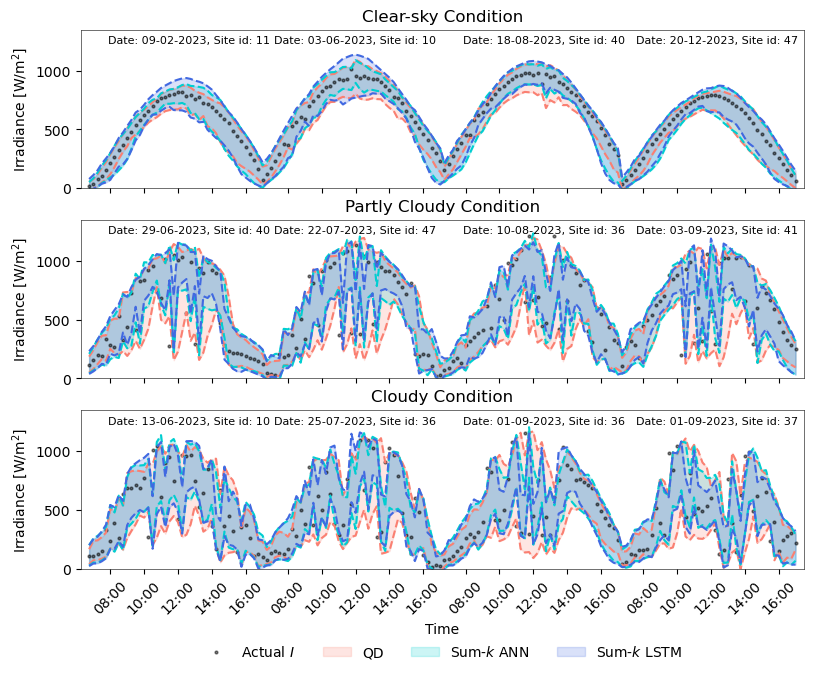

In [24]:
numcond = 1 # for compare QD and Sumk
# List to store the top 5 deviations for each sky condition
top_list = []

filtered_cond = ['deviation', 'avg_width_qd_ahead15', 'avg_width_sumk_ahead15'
               , 'model_deviation', 'avg_width_sumk_lstm_ahead15', 'avg_width_sumk_ahead15']
print(filtered_cond[numcond])
# Calculate top 5 deviations for each sky condition
for condition in sky_conditions:
    # Filter the grouped DataFrame for the specific sky condition
    filtered_df = grouped_df[grouped_df['skycondition'] == condition]
    
    top_deviation = filtered_df.nlargest(4, filtered_cond[numcond])
#     top_deviation = filtered_df.nsmallest(4, filtered_cond[numcond])
    # Add rank within each sky condition
    top_deviation['rank'] = top_deviation[filtered_cond[numcond]].rank(method='first', ascending=False).astype(int)
    
    # Append to the list
    top_list.append(top_deviation)

# Concatenate all top 5 DataFrames into a single DataFrame
top_deviation_combined = pd.concat(top_list, ignore_index=True)

# Define the specific Site_ids and corresponding dates
cloudcond_key_list = ['clearsky', 'partlycloudy', 'cloudy']
allconditions = []
for cloudcond in cloudcond_key_list:
    site_list = top_deviation_combined[top_deviation_combined['skycondition']==cloudcond]['Site_id'].to_numpy()
    date_list = top_deviation_combined[top_deviation_combined['skycondition']==cloudcond]['Date'].to_numpy()
    conditions = []
    for i in range(len(site_list)):
        cond = (df_test_date['Site_id'] == site_list[i]) & (df_test_date.index.date == date_list[i])
        conditions.append(cond)
    conditions = np.logical_or.reduce(conditions)
    allconditions.append(conditions)

# Define the plot characteristics
stepahead = 1
y_plot = y_test[:, stepahead - 1]
# conditions = [conditions_clearsky, conditions_partlycloudy, conditions_cloudy]
condname_list = ['Clear-sky', 'Partly Cloudy', 'Cloudy']
df_forindex = df_test_date.copy()
df_forindex['Date'] = df_forindex.index.date

# PI to plot
pi_plots = [result_qd['outputs_test'], torch.tensor(result_sumk_ann['outputs_test'][:, :, 9]), result_sumk_lstm['outputs_test']]
color_list = ['salmon', 'darkturquoise', 'royalblue']
formname_list = ['QD', 'Sum-$k$ ANN', 'Sum-$k$ LSTM']

fig, ax = plt.subplots(nrows=3, figsize=((4/3)*7, 1*7))
plt.subplots_adjust(hspace=0.2)

# Define the times you want to show (you can leave the dates out for this variable)
desired_times = ['08:00', '10:00', '12:00', '14:00', '16:00']

for i, condition in enumerate(allconditions):
    y_plot_condition = y_plot[condition]
    ax[i].plot(y_plot_condition, color='black', label=r'Actual $I$',
               marker='.', linestyle='', markersize=4, alpha=0.5)
    for pi, color, formname in zip(pi_plots, color_list, formname_list):
        pi_condition = pi[condition, 2 * (stepahead - 1):2 * stepahead]
        upper_plot = pi_condition[:, 1]
        lower_plot = pi_condition[:, 0]
        ax[i].plot(upper_plot, color=color, linestyle = 'dashed')
        ax[i].plot(lower_plot, color=color, linestyle = 'dashed')
        ax[i].fill_between(range(len(upper_plot)), lower_plot, upper_plot, color = color, 
                          alpha = 0.2, label = f'{formname}')

    # Get the time values from the DataFrame index
    time_values = df_forindex[condition].index

    # Create a list of positions for the desired times
    xtick_positions = [index for index, t in enumerate(time_values) if t.strftime('%H:%M') in desired_times]
    # Create formatted labels that include the date and time
    xtick_labels = [t.strftime('%H:%M') for t in time_values if t.strftime('%H:%M') in desired_times]

    # Set x-ticks and x-tick labels
    if i == len(allconditions)-1:
        ax[i].set_xticks(xtick_positions)
        ax[i].set_xticklabels(xtick_labels, rotation=45)
        ax[i].set_xlabel('Time')
    else:
        ax[i].set_xticks(xtick_positions)  # Retain the ticks (dashes)
        ax[i].set_xticklabels([]) 
        
    ax[i].set_xlim([-2, 169])
    ax[i].set_ylim([0, 1350])
    ax[i].set_ylabel(r'Irradiance $[\text{W/m}^{2}]$')
    ax[i].set_title(f'{condname_list[i]} Condition')
    
    if i == len(allconditions)-1:
        ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=  4, fontsize=10, frameon = False)
    
    text_list = []
    xcoor_fortext = [0.15, 0.38, 0.64, 0.88]
    for k in range(4):
        date_text = df_forindex.loc[condition, 'Date'].iloc[k*len(y_plot_condition)//4 + len(y_plot_condition)//8].strftime('%d-%m-%Y')
        site_text = df_forindex.loc[condition, 'Site_id'].iloc[k*len(y_plot_condition)//4 + len(y_plot_condition)//8]
        text_add = f'Date: {date_text}, Site id: {site_text}'
        text_list.append(text_add)
        
        ax[i].text(xcoor_fortext[k], 0.9, text_add, ha='center', va='bottom', 
                   transform=ax[i].transAxes, fontsize=8)
    
    # Reduce the border line thickness
    for spine in ax[i].spines.values():
        spine.set_linewidth(0.4)
    
# plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
# report_savefig('piplot_sepsky_solar_comparison_worstqdcondwithlstm_onecol', resultfolderpath = figurefolderpath)

## Compare every methods for Applied energy

In [15]:
df = df_test_date.copy()
lamb_index = 9

outputs_test_sumk_plot = torch.tensor(result_sumk_ann['outputs_test'][:,:,lamb_index])
upper_sumk = outputs_test_sumk_plot[:,1::2]
lower_sumk = outputs_test_sumk_plot[:,0::2]
width_sumk = upper_sumk - lower_sumk
df['width_sumk_ahead15'] = width_sumk[:,0]

upper_sumk_lstm = result_sumk_lstm['outputs_test'][:,1::2]
lower_sumk_lstm = result_sumk_lstm['outputs_test'][:,0::2]
width_sumk_lstm = upper_sumk_lstm - lower_sumk_lstm
df['width_sumk_lstm_ahead15'] = width_sumk_lstm[:,0]

upper_qr = result_qr['outputs_test'][:,1::2]
lower_qr = result_qr['outputs_test'][:,0::2]
width_qr = upper_qr - lower_qr
df['width_qr_ahead15'] = width_qr[:,0]

upper_cwcshri = result_cwcshri['outputs_test'][:,1::2]
lower_cwcshri = result_cwcshri['outputs_test'][:,0::2]
width_cwcshri = upper_cwcshri - lower_cwcshri
df['width_cwcshri_ahead15'] = width_cwcshri[:,0]

upper_qd = result_qd['outputs_test'][:,1::2]
lower_qd = result_qd['outputs_test'][:,0::2]
width_qd = upper_qd - lower_qd
df['width_qd_ahead15'] = width_qd[:,0]

df['Date'] = df.index.date
time_range = pd.date_range(start='06:45', end='17:00', freq='15T').time
df['counttimeslot'] = df.groupby(['Site_id', 'Date']).transform('count')['width_sumk_ahead15']
# Extract only full timeslot in the date
df = df[df['counttimeslot'] == len(time_range)] 

grouped_df = df.groupby(['Site_id', 'skycondition', 'Date', 'counttimeslot']).agg(
    avg_width_sumk_ahead15=('width_sumk_ahead15', 'mean'),
    avg_width_sumk_lstm_ahead15=('width_sumk_lstm_ahead15', 'mean'),
    avg_width_qr_ahead15=('width_qr_ahead15', 'mean'),
    avg_width_cwcshri_ahead15=('width_cwcshri_ahead15', 'mean'),
    avg_width_qd_ahead15=('width_qd_ahead15', 'mean')
).reset_index()

grouped_df['deviation'] = grouped_df['avg_width_qd_ahead15'] - grouped_df['avg_width_sumk_ahead15']
grouped_df['model_deviation'] = grouped_df['avg_width_sumk_ahead15'] - grouped_df['avg_width_sumk_lstm_ahead15']

# List of sky conditions to iterate over
sky_conditions = ['clearsky', 'partlycloudy', 'cloudy']

grouped_df

Site_id  skycondition        Date  counttimeslot  avg_width_sumk_ahead15  \
0          1      clearsky  2023-03-01             42              185.778930   
1          1      clearsky  2023-04-21             42              145.833671   
2          1        cloudy  2023-01-06             42              316.353747   
3          1        cloudy  2023-04-07             42              296.566553   
4          1        cloudy  2023-04-16             42              328.250340   
..       ...           ...         ...            ...                     ...   
220       47  partlycloudy  2023-07-22             42              377.479570   
221       47  partlycloudy  2023-08-20             42              327.639026   
222       47  partlycloudy  2023-09-21             42              286.606356   
223       47  partlycloudy  2023-10-01             42              376.529277   
224       47  partlycloudy  2023-12-15             42              261.785805   

     avg_width_sumk_lstm_ahead15  avg_width_qr_ahead15  \
0                     193.426346            196.780243   
1                     186.860626            105.756676   
2                     313.427582            322.796448   
3                     300.508850            278.712524   
4                     303.610168            381.675354   
..                           ...                   ...   
220                   348.556915            553.981384   
221                   387.179077            434.586731   
222                   266.337585            307.316925   
223                   375.674744            469.086029   
224                   244.261353            255.378632   

     avg_width_cwcshri_ahead15  avg_width_qd_ahead15   deviation  \
0                   174.082230            175.814468   -9.964462   
1                   146.101578            147.129410    1.295739   
2                   314.743042            317.128326    0.774579   
3                   219.018723            218.402390  -78.164163   
4                   293.358398            318.147125  -10.103214   
..                         ...                   ...         ...   
220                 478.547333            482.936462  105.456892   
221                 272.871094            296.208344  -31.430683   
222                 295.878571            304.877777   18.271422   
223                 407.584961            389.526581   12.997304   
224                 239.222351            253.094986   -8.690819   

     model_deviation  
0          -7.647416  
1         -41.026955  
2           2.926165  
3          -3.942297  
4          24.640171  
..               ...  
220        28.922655  
221       -59.540051  
222        20.268770  
223         0.854533  
224        17.524453  

[225 rows x 11 columns]

## Select the date based on criterion

In [16]:
filtered_cond = ['deviation', 'avg_width_qd_ahead15', 'model_deviation', 
                 'avg_width_sumk_ahead15', 'avg_width_sumk_lstm_ahead15']

numcond = 1 # for compare QD and Sumk
# List to store the top 5 deviations for each sky condition
top_list = []

print(filtered_cond[numcond])
# Calculate top 5 deviations for each sky condition
for condition in sky_conditions:
    # Filter the grouped DataFrame for the specific sky condition
    filtered_df = grouped_df[grouped_df['skycondition'] == condition]
    
    top_deviation = filtered_df.nlargest(4, filtered_cond[numcond])
#     top_deviation = filtered_df.nsmallest(4, filtered_cond[numcond])
    # Add rank within each sky condition
    top_deviation['rank'] = top_deviation[filtered_cond[numcond]].rank(method='first', ascending=False).astype(int)
    
    # Append to the list
    top_list.append(top_deviation)

# Concatenate all top 5 DataFrames into a single DataFrame
top_deviation_combined = pd.concat(top_list, ignore_index=True)

# Define the specific Site_ids and corresponding dates
cloudcond_key_list = ['clearsky', 'partlycloudy', 'cloudy']
allconditions = []
for cloudcond in cloudcond_key_list:
    site_list = top_deviation_combined[top_deviation_combined['skycondition']==cloudcond]['Site_id'].to_numpy()
    date_list = top_deviation_combined[top_deviation_combined['skycondition']==cloudcond]['Date'].to_numpy()
    conditions = []
    for i in range(len(site_list)):
        cond = (df_test_date['Site_id'] == site_list[i]) & (df_test_date.index.date == date_list[i])
        conditions.append(cond)
    conditions = np.logical_or.reduce(conditions)
    allconditions.append(conditions)

# Define the plot characteristics
stepahead = 1
y_plot = y_test[:, stepahead - 1]
# conditions = [conditions_clearsky, conditions_partlycloudy, conditions_cloudy]
condname_list = ['Clear-sky', 'Partly Cloudy', 'Cloudy']
df_forindex = df_test_date.copy()
df_forindex['Date'] = df_forindex.index.date

# PI to plot (Place the reference in the last index)
pi_plots = [result_qr['outputs_test'], result_cwcshri['outputs_test'], result_qd['outputs_test'], 
            torch.tensor(result_sumk_ann['outputs_test'][:, :, 9]), result_sumk_lstm['outputs_test']]
color_list = ['peru', 'forestgreen', 'salmon', 'darkturquoise', 'royalblue']
formname_list = ['QR', '$\\text{CWC}_{\\text{Shri}}$', 'QD', 'Sum-$k$ ANN', 'Sum-$k$ LSTM']

avg_width_qd_ahead15


## Randomly select the date

In [17]:
top_list = []
# Set the random seed for reproducibility (optional)
seed_list = [20, 20, 20]

# Select 4 random dates for each sky condition
for i, condition in enumerate(sky_conditions):
    np.random.seed(20)  
    # Filter the grouped DataFrame for the specific sky condition
    filtered_df = grouped_df[grouped_df['skycondition'] == condition]
    
    # Ensure there are at least 4 unique dates available
    unique_dates = filtered_df['Date'].unique()
    num_samples = min(4, len(unique_dates))  # Avoid errors if there are fewer than 4 dates
    
    # Randomly select 4 dates
    random_dates = np.random.choice(unique_dates, num_samples, replace=False)
    print(condition, random_dates)
    
    # Select rows corresponding to the chosen dates
    random_selection = filtered_df[filtered_df['Date'].isin(random_dates)]
    
    # Append to the list
    top_list.append(random_selection)

# Concatenate all top 5 DataFrames into a single DataFrame
top_deviation_combined = pd.concat(top_list, ignore_index=True)

# Define the specific Site_ids and corresponding dates
cloudcond_key_list = ['clearsky', 'partlycloudy', 'cloudy']
allconditions = []
for cloudcond in cloudcond_key_list:
    site_list = top_deviation_combined[top_deviation_combined['skycondition']==cloudcond]['Site_id'].to_numpy()
    date_list = top_deviation_combined[top_deviation_combined['skycondition']==cloudcond]['Date'].to_numpy()
    conditions = []
    for i in range(len(site_list)):
        cond = (df_test_date['Site_id'] == site_list[i]) & (df_test_date.index.date == date_list[i])
        conditions.append(cond)
    conditions = np.logical_or.reduce(conditions)
    allconditions.append(conditions)

# Define the plot characteristics
stepahead = 1
y_plot = y_test[:, stepahead - 1]
condname_list = ['Clear-sky', 'Partly Cloudy', 'Cloudy']
df_forindex = df_test_date.copy()
df_forindex['Date'] = df_forindex.index.date

# PI to plot (Place the reference in the last index)
pi_plots = [result_qr['outputs_test'], result_cwcshri['outputs_test'], result_qd['outputs_test'], 
            torch.tensor(result_sumk_ann['outputs_test'][:, :, 9]), result_sumk_lstm['outputs_test']]
color_list = ['peru', 'forestgreen', 'salmon', 'darkturquoise', 'royalblue']
formname_list = ['QR', '$\\text{CWC}_{\\text{Shri}}$', 'QD', 'Sum-$k$ ANN', 'Sum-$k$ LSTM']

clearsky [datetime.date(2023, 4, 15) datetime.date(2023, 1, 21)
 datetime.date(2023, 4, 21) datetime.date(2023, 12, 23)]
partlycloudy [datetime.date(2023, 7, 26) datetime.date(2023, 11, 16)
 datetime.date(2023, 6, 22) datetime.date(2023, 8, 10)]
cloudy [datetime.date(2023, 9, 4) datetime.date(2023, 10, 14)
 datetime.date(2023, 5, 3) datetime.date(2023, 9, 5)]


### Clear-sky

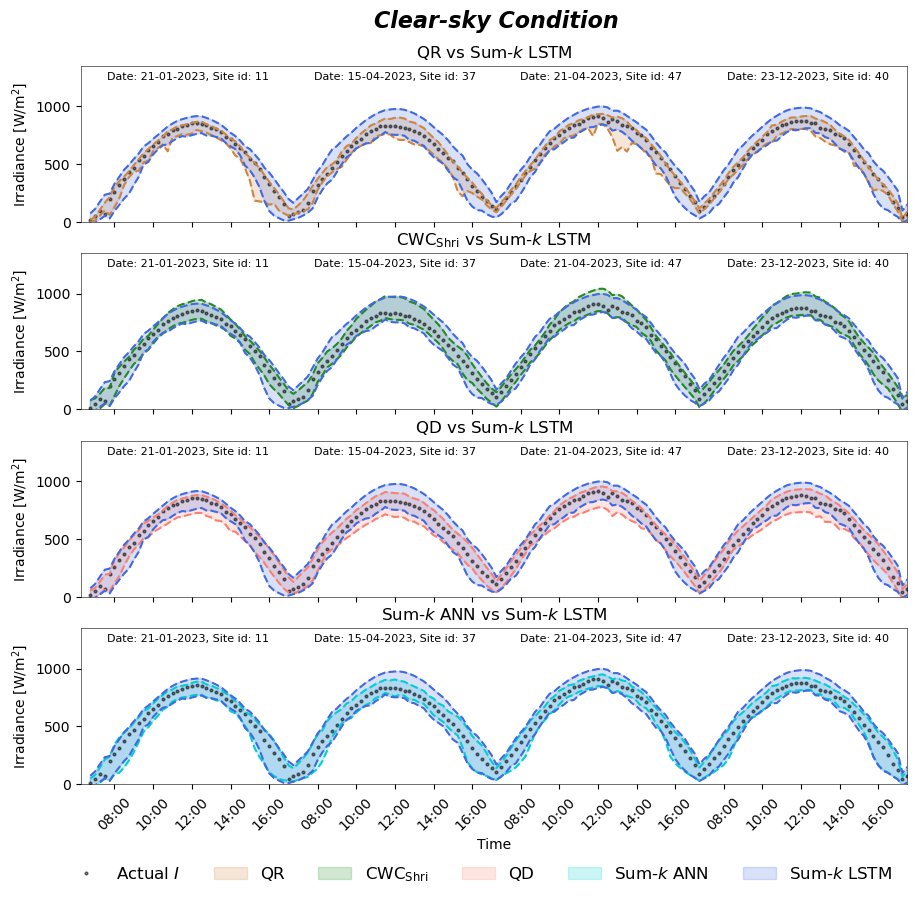

In [21]:
# fig, ax = plt.subplots(nrows=4, figsize=((4/3)*7, (4/3)*7))
fig, ax = plt.subplots(nrows=4, figsize=((4/3)*8, (4/3)*7))
plt.subplots_adjust(hspace=0.2)

condition = allconditions[0] # 0 - clear sky, 1 - partly cloudy, 2 - cloudy
y_plot_condition = y_plot[condition]
pi_ref = pi_plots[-1]

# Define the times you want to show (you can leave the dates out for this variable)
desired_times = ['08:00', '10:00', '12:00', '14:00', '16:00']
# Get the time values from the DataFrame index
time_values = df_forindex[condition].index
# Create a list of positions for the desired times
xtick_positions = [index for index, t in enumerate(time_values) if t.strftime('%H:%M') in desired_times]
# Create formatted labels that include the date and time
xtick_labels = [t.strftime('%H:%M') for t in time_values if t.strftime('%H:%M') in desired_times]

legend_handles = []
legend_labels = [r'Actual $I$'] + formname_list

for i, (pi, color, formname) in enumerate(zip(pi_plots, color_list, formname_list)):
    if i == len(pi_plots) - 1:  # Skip the last index
        break
    actual_plot, = ax[i].plot(y_plot_condition, color='black', label=r'Actual $I$',
           marker='.', linestyle='', markersize=4, alpha=0.5)
    if i == 0:
        legend_handles.append(actual_plot)
    pi_condition = pi[condition, 2 * (stepahead - 1):2 * stepahead]
    upper_plot = pi_condition[:, 1]
    lower_plot = pi_condition[:, 0]
    ax[i].plot(upper_plot, color=color, linestyle = 'dashed')
    ax[i].plot(lower_plot, color=color, linestyle = 'dashed')
    pi_benchmarked_plot = ax[i].fill_between(range(len(upper_plot)), lower_plot, upper_plot, color = color, 
                      alpha = 0.2, label = f'{formname}')
    legend_handles.append(pi_benchmarked_plot)
    
    pi_ref_condition = pi_ref[condition, 2 * (stepahead - 1):2 * stepahead]
    color_ref = color_list[-1]
    formname_ref = formname_list[-1]
    upper_plot_ref = pi_ref_condition[:, 1]
    lower_plot_ref = pi_ref_condition[:, 0]
    ax[i].plot(upper_plot_ref, color=color_ref, linestyle = 'dashed')
    ax[i].plot(lower_plot_ref, color=color_ref, linestyle = 'dashed')
    pi_ref_plot = ax[i].fill_between(range(len(upper_plot_ref)), lower_plot_ref, upper_plot_ref, color = color_ref, 
                      alpha = 0.2, label = f'{formname_ref}')
    
    if i == len(pi_plots) - 2:
        legend_handles.append(pi_ref_plot)

    # Set x-ticks and x-tick labels
    if i == len(pi_plots)-2:
        ax[i].set_xticks(xtick_positions)
        ax[i].set_xticklabels(xtick_labels, rotation=45)
        ax[i].set_xlabel('Time')
    else:
        ax[i].set_xticks(xtick_positions)  # Retain the ticks (dashes)
        ax[i].set_xticklabels([]) 

    ax[i].set_xlim([-2, 169])
    ax[i].set_ylim([0, 1350])
    ax[i].set_ylabel(r'Irradiance $[\text{W/m}^{2}]$')
    ax[i].set_title(f'{formname} vs Sum-$k$ LSTM')

#     if i == len(pi_plots)-2:
#         ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=  6, fontsize=10, frameon = False)

    text_list = []
    xcoor_fortext = [0.13, 0.38, 0.63, 0.88]
    for k in range(4):
        date_text = df_forindex.loc[condition, 'Date'].iloc[k*len(y_plot_condition)//4 + len(y_plot_condition)//8].strftime('%d-%m-%Y')
        site_text = df_forindex.loc[condition, 'Site_id'].iloc[k*len(y_plot_condition)//4 + len(y_plot_condition)//8]
        text_add = f'Date: {date_text}, Site id: {site_text}'
        text_list.append(text_add)

        ax[i].text(xcoor_fortext[k], 0.9, text_add, ha='center', va='bottom', 
                   transform=ax[i].transAxes, fontsize=8)

    # Reduce the border line thickness
    for spine in ax[i].spines.values():
        spine.set_linewidth(0.4)

# Add single legend at the bottom without duplicates
fig.legend(legend_handles, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 0.04), 
           ncol=6, fontsize=12, frameon=False)

fig.suptitle('Clear-sky Condition', fontsize=16, fontweight='bold', fontstyle='italic', y = 0.94, x = 0.515)
    
# plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
# report_savefig('piplot_clearsky_comparison_randomdates', resultfolderpath = figurefolderpath)

### Partly cloudy

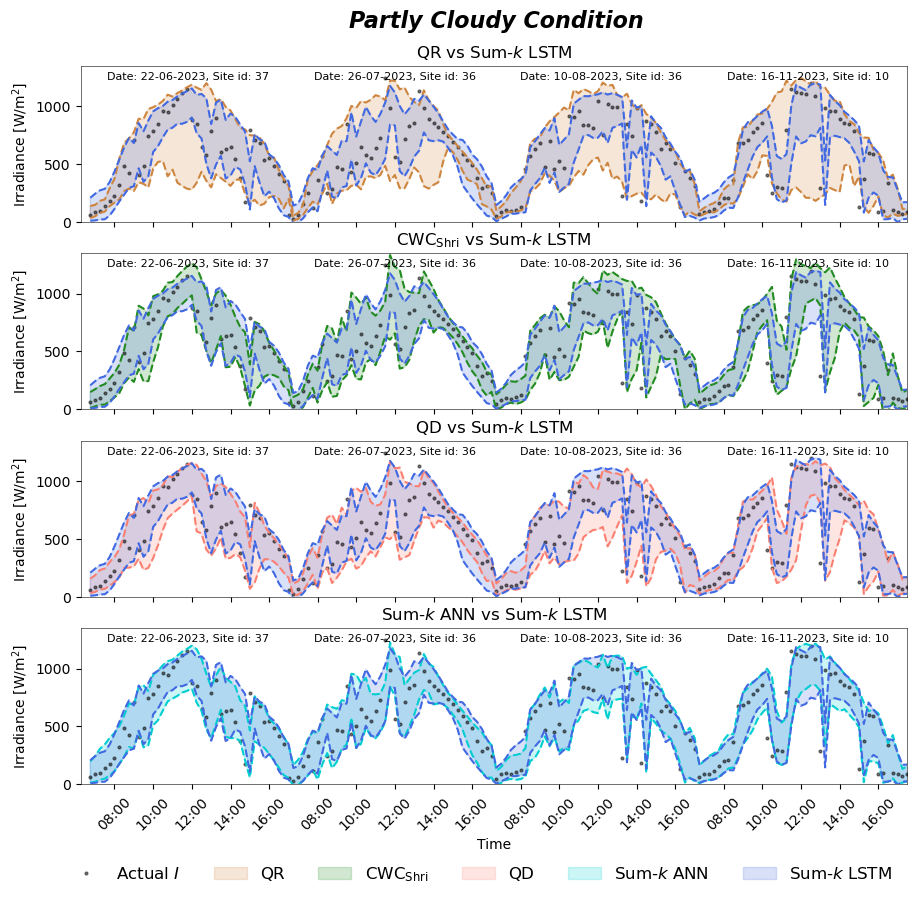

In [23]:
# fig, ax = plt.subplots(nrows=4, figsize=((4/3)*7, (4/3)*7))
fig, ax = plt.subplots(nrows=4, figsize=((4/3)*8, (4/3)*7))
plt.subplots_adjust(hspace=0.2)

condition = allconditions[1] # 0 - clear sky, 1 - partly cloudy, 2 - cloudy
y_plot_condition = y_plot[condition]
pi_ref = pi_plots[-1]

# Define the times you want to show (you can leave the dates out for this variable)
desired_times = ['08:00', '10:00', '12:00', '14:00', '16:00']
# Get the time values from the DataFrame index
time_values = df_forindex[condition].index
# Create a list of positions for the desired times
xtick_positions = [index for index, t in enumerate(time_values) if t.strftime('%H:%M') in desired_times]
# Create formatted labels that include the date and time
xtick_labels = [t.strftime('%H:%M') for t in time_values if t.strftime('%H:%M') in desired_times]

legend_handles = []
legend_labels = [r'Actual $I$'] + formname_list

for i, (pi, color, formname) in enumerate(zip(pi_plots, color_list, formname_list)):
    if i == len(pi_plots) - 1:  # Skip the last index
        break
    actual_plot, = ax[i].plot(y_plot_condition, color='black', label=r'Actual $I$',
           marker='.', linestyle='', markersize=4, alpha=0.5)
    if i == 0:
        legend_handles.append(actual_plot)
    pi_condition = pi[condition, 2 * (stepahead - 1):2 * stepahead]
    upper_plot = pi_condition[:, 1]
    lower_plot = pi_condition[:, 0]
    ax[i].plot(upper_plot, color=color, linestyle = 'dashed')
    ax[i].plot(lower_plot, color=color, linestyle = 'dashed')
    pi_benchmarked_plot = ax[i].fill_between(range(len(upper_plot)), lower_plot, upper_plot, color = color, 
                      alpha = 0.2, label = f'{formname}')
    legend_handles.append(pi_benchmarked_plot)
    
    pi_ref_condition = pi_ref[condition, 2 * (stepahead - 1):2 * stepahead]
    color_ref = color_list[-1]
    formname_ref = formname_list[-1]
    upper_plot_ref = pi_ref_condition[:, 1]
    lower_plot_ref = pi_ref_condition[:, 0]
    ax[i].plot(upper_plot_ref, color=color_ref, linestyle = 'dashed')
    ax[i].plot(lower_plot_ref, color=color_ref, linestyle = 'dashed')
    pi_ref_plot = ax[i].fill_between(range(len(upper_plot_ref)), lower_plot_ref, upper_plot_ref, color = color_ref, 
                      alpha = 0.2, label = f'{formname_ref}')
    
    if i == len(pi_plots) - 2:
        legend_handles.append(pi_ref_plot)

    # Set x-ticks and x-tick labels
    if i == len(pi_plots)-2:
        ax[i].set_xticks(xtick_positions)
        ax[i].set_xticklabels(xtick_labels, rotation=45)
        ax[i].set_xlabel('Time')
    else:
        ax[i].set_xticks(xtick_positions)  # Retain the ticks (dashes)
        ax[i].set_xticklabels([]) 

    ax[i].set_xlim([-2, 169])
    ax[i].set_ylim([0, 1350])
    ax[i].set_ylabel(r'Irradiance $[\text{W/m}^{2}]$')
    ax[i].set_title(f'{formname} vs Sum-$k$ LSTM')

#     if i == len(pi_plots)-2:
#         ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=  6, fontsize=10, frameon = False)

    text_list = []
    xcoor_fortext = [0.13, 0.38, 0.63, 0.88]
    for k in range(4):
        date_text = df_forindex.loc[condition, 'Date'].iloc[k*len(y_plot_condition)//4 + len(y_plot_condition)//8].strftime('%d-%m-%Y')
        site_text = df_forindex.loc[condition, 'Site_id'].iloc[k*len(y_plot_condition)//4 + len(y_plot_condition)//8]
        text_add = f'Date: {date_text}, Site id: {site_text}'
        text_list.append(text_add)

        ax[i].text(xcoor_fortext[k], 0.9, text_add, ha='center', va='bottom', 
                   transform=ax[i].transAxes, fontsize=8)

    # Reduce the border line thickness
    for spine in ax[i].spines.values():
        spine.set_linewidth(0.4)

# Add single legend at the bottom without duplicates
fig.legend(legend_handles, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 0.04), 
           ncol=6, fontsize=12, frameon=False)

fig.suptitle('Partly Cloudy Condition', fontsize=16, fontweight='bold', fontstyle='italic', y = 0.94, x = 0.515)
    
# plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
# report_savefig('piplot_partlycloudysky_comparison_randomdates', resultfolderpath = figurefolderpath)

### Cloudy

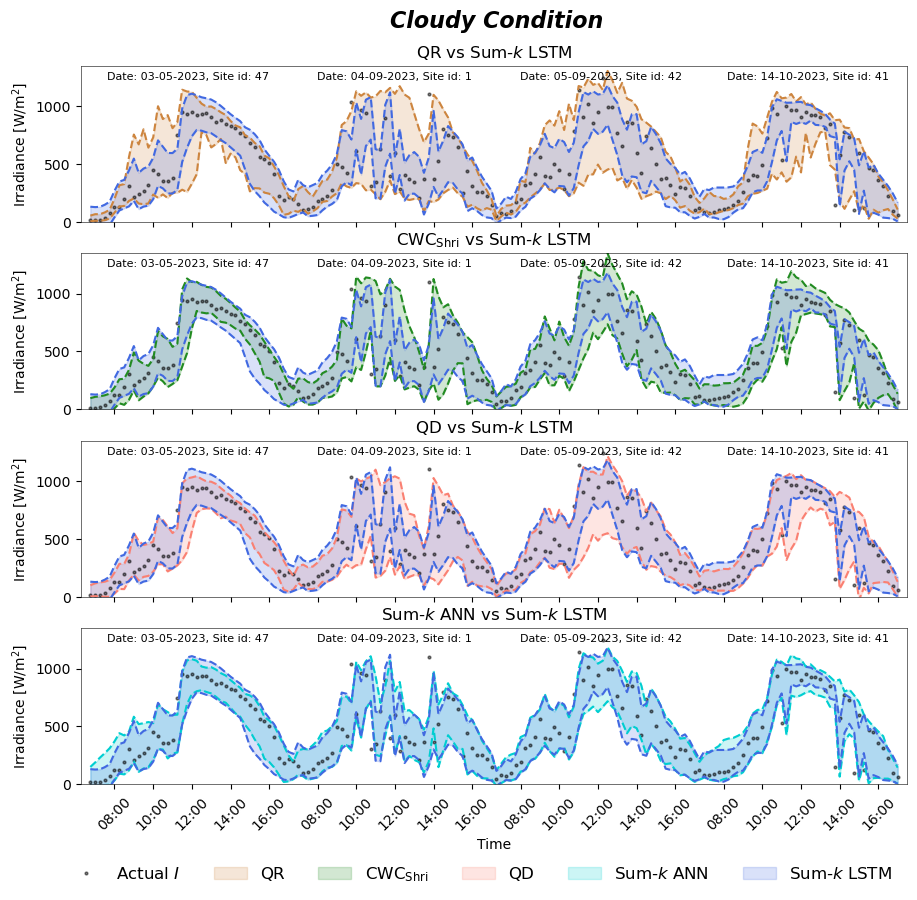

In [24]:
# fig, ax = plt.subplots(nrows=4, figsize=((4/3)*7, (4/3)*7))
fig, ax = plt.subplots(nrows=4, figsize=((4/3)*8, (4/3)*7))
plt.subplots_adjust(hspace=0.2)

condition = allconditions[2] # 0 - clear sky, 1 - partly cloudy, 2 - cloudy
y_plot_condition = y_plot[condition]
pi_ref = pi_plots[-1]

# Define the times you want to show (you can leave the dates out for this variable)
desired_times = ['08:00', '10:00', '12:00', '14:00', '16:00']
# Get the time values from the DataFrame index
time_values = df_forindex[condition].index
# Create a list of positions for the desired times
xtick_positions = [index for index, t in enumerate(time_values) if t.strftime('%H:%M') in desired_times]
# Create formatted labels that include the date and time
xtick_labels = [t.strftime('%H:%M') for t in time_values if t.strftime('%H:%M') in desired_times]

legend_handles = []
legend_labels = [r'Actual $I$'] + formname_list

for i, (pi, color, formname) in enumerate(zip(pi_plots, color_list, formname_list)):
    if i == len(pi_plots) - 1:  # Skip the last index
        break
    actual_plot, = ax[i].plot(y_plot_condition, color='black', label=r'Actual $I$',
           marker='.', linestyle='', markersize=4, alpha=0.5)
    if i == 0:
        legend_handles.append(actual_plot)
    pi_condition = pi[condition, 2 * (stepahead - 1):2 * stepahead]
    upper_plot = pi_condition[:, 1]
    lower_plot = pi_condition[:, 0]
    ax[i].plot(upper_plot, color=color, linestyle = 'dashed')
    ax[i].plot(lower_plot, color=color, linestyle = 'dashed')
    pi_benchmarked_plot = ax[i].fill_between(range(len(upper_plot)), lower_plot, upper_plot, color = color, 
                      alpha = 0.2, label = f'{formname}')
    legend_handles.append(pi_benchmarked_plot)
    
    pi_ref_condition = pi_ref[condition, 2 * (stepahead - 1):2 * stepahead]
    color_ref = color_list[-1]
    formname_ref = formname_list[-1]
    upper_plot_ref = pi_ref_condition[:, 1]
    lower_plot_ref = pi_ref_condition[:, 0]
    ax[i].plot(upper_plot_ref, color=color_ref, linestyle = 'dashed')
    ax[i].plot(lower_plot_ref, color=color_ref, linestyle = 'dashed')
    pi_ref_plot = ax[i].fill_between(range(len(upper_plot_ref)), lower_plot_ref, upper_plot_ref, color = color_ref, 
                      alpha = 0.2, label = f'{formname_ref}')
    
    if i == len(pi_plots) - 2:
        legend_handles.append(pi_ref_plot)

    # Set x-ticks and x-tick labels
    if i == len(pi_plots)-2:
        ax[i].set_xticks(xtick_positions)
        ax[i].set_xticklabels(xtick_labels, rotation=45)
        ax[i].set_xlabel('Time')
    else:
        ax[i].set_xticks(xtick_positions)  # Retain the ticks (dashes)
        ax[i].set_xticklabels([]) 

    ax[i].set_xlim([-2, 169])
    ax[i].set_ylim([0, 1350])
    ax[i].set_ylabel(r'Irradiance $[\text{W/m}^{2}]$')
    ax[i].set_title(f'{formname} vs Sum-$k$ LSTM')

#     if i == len(pi_plots)-2:
#         ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=  6, fontsize=10, frameon = False)

    text_list = []
    xcoor_fortext = [0.13, 0.38, 0.63, 0.88]
    for k in range(4):
        date_text = df_forindex.loc[condition, 'Date'].iloc[k*len(y_plot_condition)//4 + len(y_plot_condition)//8].strftime('%d-%m-%Y')
        site_text = df_forindex.loc[condition, 'Site_id'].iloc[k*len(y_plot_condition)//4 + len(y_plot_condition)//8]
        text_add = f'Date: {date_text}, Site id: {site_text}'
        text_list.append(text_add)

        ax[i].text(xcoor_fortext[k], 0.9, text_add, ha='center', va='bottom', 
                   transform=ax[i].transAxes, fontsize=8)

    # Reduce the border line thickness
    for spine in ax[i].spines.values():
        spine.set_linewidth(0.4)

# Add single legend at the bottom without duplicates
fig.legend(legend_handles, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 0.04), 
           ncol=6, fontsize=12, frameon=False)

fig.suptitle('Cloudy Condition', fontsize=16, fontweight='bold', fontstyle='italic', y = 0.94, x = 0.515)
    
# plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
# report_savefig('piplot_cloudysky_comparison_randomdates', resultfolderpath = figurefolderpath)

# Forecasting plot

Skycondition: partlycloudy
Date: 2023-08-21
Site id:11


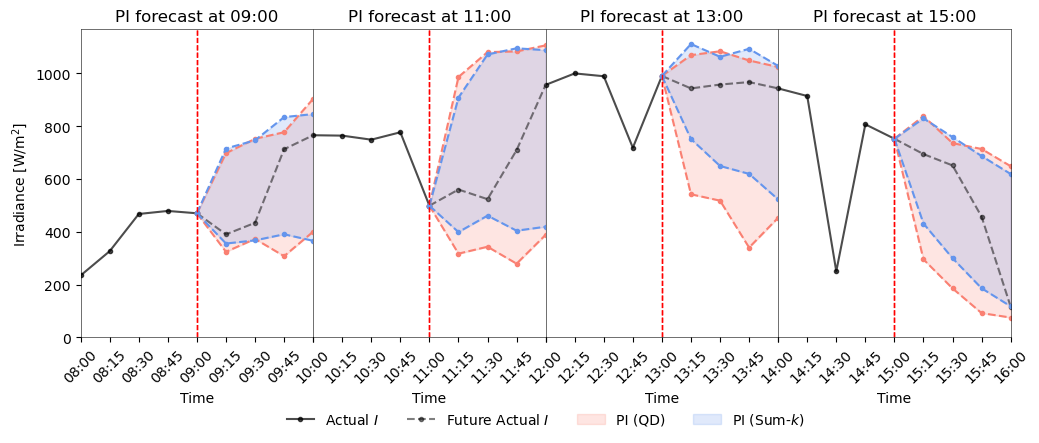

In [69]:
df = df_test_date.copy()
randomdate_df, mask_date = randomly_selected_date(df_test_date, random_seed = None)
# Select date for plot
mask_date = (df.index.date == pd.to_datetime('2023-08-21').date()) & (df['Site_id']==11).to_numpy()
randomdate_df = df[mask_date]

skycond = randomdate_df['skycondition'].iloc[0]
date = randomdate_df.index.date[0]
siteid = randomdate_df['Site_id'].iloc[0]
print(f'Skycondition: {skycond}')
print(f'Date: {date}')
print(f'Site id:{siteid}')

time_list_plot = ['09:00', '11:00', '13:00', '15:00']

pi_plots = [result_qd['outputs_test'], torch.tensor(result_sumk_ann['outputs_test'][:, :, 9])]
color_list = ['salmon', 'cornflowerblue']
formname_list = ['QD', 'Sum-$k$']
max_upper = 0

if len(time_list_plot) == 1:
    fig, ax = plt.subplots(ncols = len(time_list_plot), figsize = (8, 4))
    ax = [ax]
else:
    fig, ax = plt.subplots(ncols = len(time_list_plot), figsize = (12, 4), gridspec_kw={'wspace': 0})

for i, time_plot in enumerate(time_list_plot):
    # Define the start and end times as datetime
    start_time = pd.to_datetime(time_list_plot[i]) - pd.Timedelta(hours=1)
    plot_time = pd.to_datetime(time_plot)

    time_mask = df.index.time == plot_time.time()
    mask = mask_date & time_mask
    # Generate the time range and extract the time part as a list
    time_steps_str = [t.strftime('%H:%M') for t in 
                      pd.date_range(start = start_time, end=plot_time + pd.Timedelta(hours=1)
                                    , freq='15T').time.tolist()]

    extracted_df = randomdate_df.between_time(start_time.time(), plot_time.time())
    historicaldata = (extracted_df['I']).to_numpy()
    targetahead = extracted_df.to_numpy()[-1, -4:]
    plotdata = np.hstack([historicaldata, targetahead])
    
    ax[i].plot(time_steps_str[:-4], plotdata[:-4], marker = '.', color = 'black', alpha = 0.7, label = r'Actual $I$')
    ax[i].plot(time_steps_str[-5:], plotdata[-5:], marker = '.', color = 'black',linestyle = 'dashed', alpha = 0.5
               , label = r'Future Actual $I$')
    
    for pi_plot, color, formname in zip(pi_plots, color_list, formname_list):
        upper = pi_plot[mask, 1::2].numpy().reshape(-1)
        lower = pi_plot[mask, 0::2].numpy().reshape(-1)
        
        if upper.max() > max_upper or plotdata.max() > max_upper:
            max_upper = max(upper.max(), plotdata.max())
        
        ax[i].plot(time_steps_str[-5:], np.insert(upper, 0, historicaldata[-1])
                   , marker = '.', linestyle = 'dashed', color = color)
        ax[i].plot(time_steps_str[-5:], np.insert(lower, 0, historicaldata[-1])
                   , marker = '.', linestyle = 'dashed', color = color)
        ax[i].fill_between(time_steps_str[-5:], np.insert(lower, 0, historicaldata[-1]), np.insert(upper, 0, historicaldata[-1]), color = color, 
                              alpha = 0.2, label = f'PI ({formname})')
        ax[i].axvline(plot_time.strftime('%H:%M'), color='red', linestyle='--', linewidth = 1)
        
    ax[i].set_xlabel('Time')
    ax[i].set_title(f'PI forecast at {time_plot}')
    ax[i].set_xticks(time_steps_str)  # Set x-ticks to the generated time strings
    ax[i].set_xticklabels(time_steps_str, rotation=45)
    ax[i].set_xlim([time_steps_str[0], time_steps_str[-1]])
    
    if i == len(time_list_plot)-2:
        ax[i].legend(loc='upper center', bbox_to_anchor=(0, -0.2), ncol=  4, fontsize=10, frameon = False)

    if i == 0:
        ax[i].set_ylabel(r'Irradiance [$\text{W/m}^{2}$]')
    else:
        ax[i].tick_params(labelleft=False)  # Hide y-axis labels for other subplots
        ax[i].set_yticks([])
        xticks = ax[i].get_xticks()
        xtick_labels = ax[i].get_xticklabels()
        xtick_labels[0] = ''
        ax[i].set_xticklabels(xtick_labels)

    if i != len(time_list_plot)-1:
        ax[i].spines['right'].set_visible(False)

for i, time_plot in enumerate(time_list_plot):
    ax[i].set_ylim([0, max_upper*1.05])
    
for axis in ax:
    for spine in axis.spines.values():
        spine.set_linewidth(0.4)
    
# plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

datefilename = f'{date}'.replace('-','')
# report_savefig(f'piplot_forecast_horizontal_solar_comparison_{datefilename}_site{siteid}', resultfolderpath = figurefolderpath)


Skycondition: cloudy
Date: 2023-10-06
Site id:39


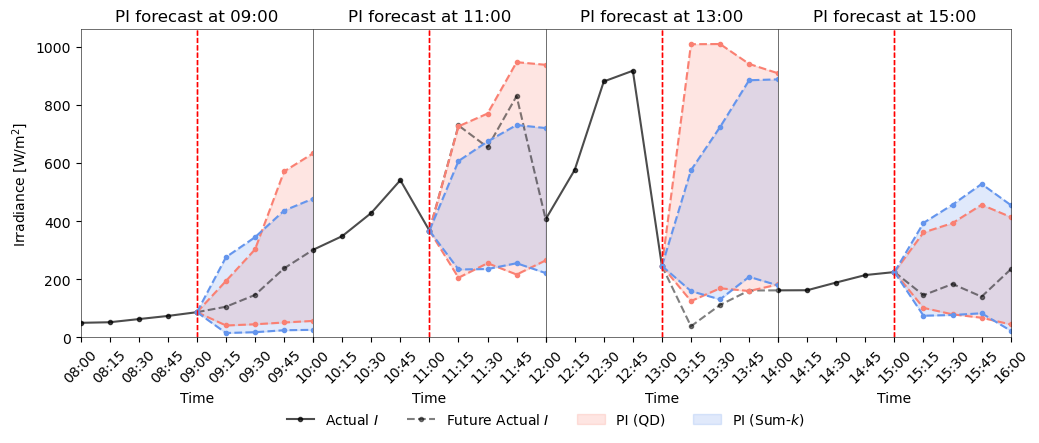

In [70]:
df = df_test_date.copy()
randomdate_df, mask_date =randomly_selected_date(df_test_date, random_seed = None)
# Select date for plot
mask_date = (df.index.date == pd.to_datetime('2023-10-06').date()) & (df['Site_id']==39).to_numpy()
randomdate_df = df[mask_date]

skycond = randomdate_df['skycondition'].iloc[0]
date = randomdate_df.index.date[0]
siteid = randomdate_df['Site_id'].iloc[0]
print(f'Skycondition: {skycond}')
print(f'Date: {date}')
print(f'Site id:{siteid}')

time_list_plot = ['09:00', '11:00', '13:00', '15:00']

pi_plots = [result_qd['outputs_test'], torch.tensor(result_sumk_ann['outputs_test'][:, :, 9])]
color_list = ['salmon', 'cornflowerblue']
formname_list = ['QD', 'Sum-$k$']
max_upper = 0

if len(time_list_plot) == 1:
    fig, ax = plt.subplots(ncols = len(time_list_plot), figsize = (8, 4))
    ax = [ax]
else:
    fig, ax = plt.subplots(ncols = len(time_list_plot), figsize = (12, 4), gridspec_kw={'wspace': 0})

for i, time_plot in enumerate(time_list_plot):
    # Define the start and end times as datetime
    start_time = pd.to_datetime(time_list_plot[i]) - pd.Timedelta(hours=1)
    plot_time = pd.to_datetime(time_plot)

    time_mask = df.index.time == plot_time.time()
    mask = mask_date & time_mask
    # Generate the time range and extract the time part as a list
    time_steps_str = [t.strftime('%H:%M') for t in 
                      pd.date_range(start = start_time, end=plot_time + pd.Timedelta(hours=1)
                                    , freq='15T').time.tolist()]

    extracted_df = randomdate_df.between_time(start_time.time(), plot_time.time())
    historicaldata = (extracted_df['I']).to_numpy()
    targetahead = extracted_df.to_numpy()[-1, -4:]
    plotdata = np.hstack([historicaldata, targetahead])
    
    ax[i].plot(time_steps_str[:-4], plotdata[:-4], marker = '.', color = 'black', alpha = 0.7, label = r'Actual $I$')
    ax[i].plot(time_steps_str[-5:], plotdata[-5:], marker = '.', color = 'black',linestyle = 'dashed', alpha = 0.5
               , label = r'Future Actual $I$')
    
    for pi_plot, color, formname in zip(pi_plots, color_list, formname_list):
        upper = pi_plot[mask, 1::2].numpy().reshape(-1)
        lower = pi_plot[mask, 0::2].numpy().reshape(-1)
        
        if upper.max() > max_upper or plotdata.max() > max_upper:
            max_upper = max(upper.max(), plotdata.max())
        
        ax[i].plot(time_steps_str[-5:], np.insert(upper, 0, historicaldata[-1])
                   , marker = '.', linestyle = 'dashed', color = color)
        ax[i].plot(time_steps_str[-5:], np.insert(lower, 0, historicaldata[-1])
                   , marker = '.', linestyle = 'dashed', color = color)
        ax[i].fill_between(time_steps_str[-5:], np.insert(lower, 0, historicaldata[-1]), np.insert(upper, 0, historicaldata[-1]), color = color, 
                              alpha = 0.2, label = f'PI ({formname})')
        ax[i].axvline(plot_time.strftime('%H:%M'), color='red', linestyle='--', linewidth = 1)
        
    ax[i].set_xlabel('Time')
    ax[i].set_title(f'PI forecast at {time_plot}')
    ax[i].set_xticks(time_steps_str)  # Set x-ticks to the generated time strings
    ax[i].set_xticklabels(time_steps_str, rotation=45)
    ax[i].set_xlim([time_steps_str[0], time_steps_str[-1]])
    
    if i == len(time_list_plot)-2:
        ax[i].legend(loc='upper center', bbox_to_anchor=(0, -0.2), ncol=  4, fontsize=10, frameon = False)

    if i == 0:
        ax[i].set_ylabel(r'Irradiance [$\text{W/m}^{2}$]')
    else:
        ax[i].tick_params(labelleft=False)  # Hide y-axis labels for other subplots
        ax[i].set_yticks([])
        xticks = ax[i].get_xticks()
        xtick_labels = ax[i].get_xticklabels()
        xtick_labels[0] = ''
        ax[i].set_xticklabels(xtick_labels)

    if i != len(time_list_plot)-1:
        ax[i].spines['right'].set_visible(False)

for i, time_plot in enumerate(time_list_plot):
    ax[i].set_ylim([0, max_upper*1.05])
    
for axis in ax:
    for spine in axis.spines.values():
        spine.set_linewidth(0.4)
    
# plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

datefilename = f'{date}'.replace('-','')
# report_savefig(f'piplot_forecast_horizontal_solar_comparison_{datefilename}_site{siteid}', resultfolderpath = figurefolderpath)


# Evaluation cost of PI with point forecast

## Import data

In [2]:
dict_path = os.path.join(datafolderpath, 'data_central_train_nonan.pkl')
with open(dict_path, 'rb') as pickle_file:
    data = pickle.load(pickle_file)
print(data.keys())

X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']
y_all = torch.cat([y_train, y_val, y_test], dim = 0)

target_col = data['target_col']
features_list = data['features_list']
future_regressor = data['future_regressor']

df_train_date = data['df_train_date']
df_val_date = data['df_val_date']
df_test_date = data['df_test_date']
df_all_date = pd.concat([df_train_date, df_val_date, df_test_date])

num_step_ahead = data['num_step_ahead']
resolution = data['resolution']

df_test_features = data['df_test_nonan'] # For feature plotting

dict_keys(['X_train', 'y_train', 'X_val', 'y_val', 'X_test', 'y_test', 'target_col', 'features_list', 'future_regressor', 'df_train_nonan', 'df_val_nonan', 'df_test_nonan', 'df_train_date', 'df_val_date', 'df_test_date', 'timerange', 'num_step_ahead', 'resolution'])


## Import result

In [3]:
allresult_filename = ['sumk_solarcentral_4step_varylambda.pkl', 'sumk_lstm45_solarcentral_4step.pkl'
                      , 'qd_solarcentral_4step.pkl'
                      , 'cwcshri_solarcentral_4step.pkl', 'qr_solarcentral_4step.pkl']

index_path = next((i for i, s in enumerate(allresult_filename) if 'sumk_' in s), None)
dict_path = os.path.join(saveresultfolderpath, allresult_filename[index_path])
with open(dict_path, 'rb') as pickle_file:
    result_sumk_ann = pickle.load(pickle_file)
print(result_sumk_ann.keys())

outputs_train_sumk = torch.from_numpy(result_sumk_ann['outputs_train'][:,:,9])
outputs_val_sumk = torch.from_numpy(result_sumk_ann['outputs_val'][:,:,9])
outputs_test_sumk = torch.from_numpy(result_sumk_ann['outputs_test'][:,:,9])
outputs_all_sumk = torch.cat([outputs_train_sumk, outputs_val_sumk, outputs_test_sumk], dim = 0)

index_path = next((i for i, s in enumerate(allresult_filename) if 'qd' in s), None)
dict_path = os.path.join(saveresultfolderpath, allresult_filename[index_path])
with open(dict_path, 'rb') as pickle_file:
    result_qd = pickle.load(pickle_file)
print(result_qd.keys()) 

outputs_train_qd = result_qd['outputs_train']
outputs_val_qd = result_qd['outputs_val']
outputs_test_qd = result_qd['outputs_test']
outputs_all_qd = torch.cat([outputs_train_qd, outputs_val_qd, outputs_test_qd], dim = 0)

index_path = next((i for i, s in enumerate(allresult_filename) if 'cwcshri' in s), None)
dict_path = os.path.join(saveresultfolderpath, allresult_filename[index_path])
with open(dict_path, 'rb') as pickle_file:
    result_cwcshri = pickle.load(pickle_file)
print(result_cwcshri.keys())

outputs_train_cwc = result_cwcshri['outputs_train']
outputs_val_cwc = result_cwcshri['outputs_val']
outputs_test_cwc = result_cwcshri['outputs_test']
outputs_all_cwc = torch.cat([outputs_train_cwc, outputs_val_cwc, outputs_test_cwc], dim = 0)

index_path = next((i for i, s in enumerate(allresult_filename) if 'qr' in s), None)
dict_path = os.path.join(saveresultfolderpath, allresult_filename[index_path])
with open(dict_path, 'rb') as pickle_file:
    result_qr = pickle.load(pickle_file)
print(result_qr.keys())

outputs_train_qr = result_qr['outputs_train']
outputs_val_qr = result_qr['outputs_val']
outputs_test_qr = result_qr['outputs_test']
outputs_all_qr = torch.cat([outputs_train_qr, outputs_val_qr, outputs_test_qr], dim = 0)

dict_path = os.path.join(saveresultfolderpath, 'point_solarcentral_4step.pkl')
# dict_path = os.path.join(saveresultfolderpath, 'pointadjusted_solarcentral_4step.pkl')
with open(dict_path, 'rb') as pickle_file:
    result_point = pickle.load(pickle_file)
print(result_qr.keys())

outputs_train_point = result_point['outputs_train_point']
outputs_val_point = result_point['outputs_val_point']
outputs_test_point = result_point['outputs_test_point']
outputs_point_all = torch.cat([outputs_train_point, outputs_val_point, outputs_test_point], dim = 0)

## Define model and trainer
train = trainer_multistep(num_epochs = 2000, batch_size = 2000, patience = 200) #Set the trainer

# Exclude QR in comparison
outputs_pi_all = torch.stack([outputs_all_qd, outputs_all_cwc, outputs_all_sumk], dim = 2)

if len(outputs_point_all.shape) == 2:
    print('Use only one forecast model')
    outputs_point_all = outputs_point_all.unsqueeze(-1).repeat(1, 1, outputs_pi_all.shape[2])
else:
    print('Use different forecast model')
    pass

dict_keys(['outputs_train', 'outputs_val', 'outputs_test', 'PICP_val', 'PICP_test', 'PINAW_test', 'PINALW_test', 'gamma', 'lambda'])
dict_keys(['outputs_train', 'outputs_val', 'outputs_test', 'gamma'])
dict_keys(['outputs_train', 'outputs_val', 'outputs_test', 'gamma'])
dict_keys(['outputs_train', 'outputs_val', 'outputs_test'])
dict_keys(['outputs_train', 'outputs_val', 'outputs_test'])
Use only one forecast model


## QR have crossing quantile between upper and lower bound -> exclude from comparison

In [4]:
print('  QR      1   2     3    4 step-ahead')
print(torch.sum(outputs_all_qr[:, 1::2] < outputs_all_qr[:, 0::2], axis = 0))
print('----- QR have crossing quantile, so we exclude this from comparison -----')
print('  QD    1  2  3  4 step-ahead')
print(torch.sum(outputs_all_qd[:, 1::2] < outputs_all_qd[:, 0::2], axis = 0))
print('  CWC   1  2  3  4 step-ahead')
print(torch.sum(outputs_all_cwc[:, 1::2] < outputs_all_cwc[:, 0::2], axis = 0))
print('  Sum-k 1  2  3  4 step-ahead')
print(torch.sum(outputs_all_sumk[:, 1::2] < outputs_all_sumk[:, 0::2], axis = 0))

  QR      1   2     3    4 step-ahead
tensor([  0, 218,   3,   0])
----- QR have crossing quantile, so we exclude this from comparison -----
  QD    1  2  3  4 step-ahead
tensor([0, 0, 0, 0])
  CWC   1  2  3  4 step-ahead
tensor([0, 0, 0, 0])
  Sum-k 1  2  3  4 step-ahead
tensor([0, 0, 0, 0])


## Adjust point forecast to lie in PI in every methods: QD, CWC, Sum-k

In [5]:
# ADJUST point forecast based on all PI
upper_all = outputs_pi_all[:, 1::2,:]
lower_all = outputs_pi_all[:, 0::2,:]

lowest_upper = torch.min(upper_all, dim=2).values
highest_lower = torch.max(lower_all, dim=2).values
midpoint_pi = (lowest_upper + highest_lower)/2

mask_outside_pi = (outputs_point_all < lower_all) | (outputs_point_all > upper_all)
mask_outside_allmethods = torch.any(mask_outside_pi, axis=2)

point_adjusted = torch.where(mask_outside_allmethods, midpoint_pi, outputs_point_all[:,:,0])
outputs_point_all = point_adjusted.unsqueeze(-1).repeat(1, 1, outputs_pi_all.shape[2])

# Check point forecast lie in PI for all methods

upper_all_check = outputs_pi_all[:, 1::2, :]
lower_all_check = outputs_pi_all[:, 0::2, :]

print('Check that point forecast lie within the PI for all methods.')
print('        QD CW Sum-k')
print(torch.sum((outputs_point_all > upper_all_check) | (outputs_point_all < lower_all_check), axis = 0))

Check that point forecast lie within the PI for all methods.
        QD CW Sum-k
tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])


## Evaluate the result

### In case of specific site

In [219]:
site_id = 42 # central_site = [1, 10, 11, 36, 37, 39, 40, 41, 42, 47]
site_index = (df_all_date['Site_id'] == site_id).values
df_site = df_all_date.iloc[site_index]
pi_site = outputs_pi_all[site_index].numpy()
y_site = y_all[site_index].numpy()
y_site = np.repeat(y_site[:, :, np.newaxis], pi_site.shape[2], axis = 2)
y_pred_site = outputs_point_all[site_index].numpy() # Shape (N, num_step_ahead, num_methods)

### In case of all sites

In [6]:
df_site = df_all_date
pi_site = outputs_pi_all.numpy()
y_site = y_all.numpy()
y_site = np.repeat(y_site[:, :, np.newaxis], pi_site.shape[2], axis = 2)
y_pred_site = outputs_point_all.numpy() # Shape (N, num_step_ahead, num_methods)

### Cost evaluation

In [7]:
def cost_evaluation_calculation(y_true, y_pred, upper_pred, lower_pred, df_skycond, return_reserve = True, 
                   ur_pro = (5.5, 7.5), dr_pro = (0.08, 0.1), ur_def = (55, 75), dr_def = (0.8, 1)
                    , cutpoint_energy = 30):
    desired_capacity = 100 # (MW)
    # Conversion factor to convert irradiance to solar power W/sqm to MWh
    # Jinko Solar Panel model no. 72HC 550 W: panel dimension 2278 x 1134 x 30 mm with Pmax = 550 W
    conversion_factor = ((2.278*1.134/550)*desired_capacity)/4
    
    # ur_pro = 4.8 # UR provision price [$/MWh]
    # dr_pro = 0.07 # DR provision price [$/MWh]
    # ur_def = 500 # UR deficit price [$/MWh]
    # dr_def = 30 # DR deficit price [$/MWh]
    
#     ur_pro = 1 # UR provision price [$/MWh]
#     dr_pro = 1 # DR provision price [$/MWh]
#     ur_def = 50 # UR deficit price [$/MWh]
#     dr_def = 1 # DR deficit price [$/MWh]
    
    # Calculate reserve in the unit of MWh
    r_ur = (y_pred - lower_pred)*conversion_factor # The UR deployments
    r_dr = (upper_pred - y_pred)*conversion_factor # The DR deployments
    r_ur_def = np.maximum(lower_pred - y_true, 0.0)*conversion_factor # The UR deficits
    r_dr_def = np.maximum(y_true - upper_pred, 0.0)*conversion_factor # The DR deficits
    
    cutpoint_energy_ur = cutpoint_energy
    cutpoint_energy_dr = cutpoint_energy
    
    cost_ur = (r_ur <= cutpoint_energy_ur)*ur_pro[0]*r_ur + (r_ur > cutpoint_energy_ur)*ur_pro[1]*r_ur
    cost_dr = (r_dr <= cutpoint_energy_dr)*dr_pro[0]*r_dr + (r_dr > cutpoint_energy_dr)*dr_pro[1]*r_dr

    cutpoint_energy_ur_def = cutpoint_energy
    cutpoint_energy_dr_def = cutpoint_energy
    
#     cost_ur_def = ur_def*r_ur_def # Shape (N, num_step_ahead, num_methods)
#     cost_dr_def = dr_def*r_dr_def # Shape (N, num_step_ahead, num_methods)
    
    cost_ur_def = (r_ur_def <= cutpoint_energy_ur_def)*ur_def[0]*r_ur_def + (r_ur_def > cutpoint_energy_ur_def)*ur_def[1]*r_ur_def
    cost_dr_def = (r_dr_def <= cutpoint_energy_dr_def)*dr_def[0]*r_dr_def + (r_dr_def > cutpoint_energy_dr_def)*dr_def[1]*r_dr_def
    
    # (N, (cost_ur, cost_dr, cost_ur_def, cost_dr_def), num_step_ahead, num_methods)
    cost_array = np.stack([cost_ur, cost_ur_def, cost_dr, cost_dr_def], axis = 1)
    cost_array_list = []
    sky_conditions = ['clearsky', 'partlycloudy', 'cloudy']

    for i, condition in enumerate(sky_conditions):
        sky_condition_mask = (df_skycond['skycondition'] == condition).values[:, np.newaxis, np.newaxis, np.newaxis]
        cost_array_skycond = sky_condition_mask*cost_array
        cost_array_list.append(cost_array_skycond)

    # (N, (cost_ur, cost_dr, cost_ur_def, cost_dr_def), num_step_ahead, (clearsky, partlycloudy, cloudy), num_methods)
    cost_array_total = np.stack(cost_array_list, axis = 3)
    
    if return_reserve:
        return cost_array_total, (r_ur, r_dr, r_ur_def, r_dr_def)
    else:
        return cost_array_total

#### Case 10X

In [8]:
upper_pred_site = pi_site[:, 1::2, :] # Shape (N, num_step_ahead, num_methods)
lower_pred_site = pi_site[:, 0::2, :]# Shape (N, num_step_ahead, num_methods)

cost_array_total_10x, reserve = cost_evaluation_calculation(y_site, y_pred_site, upper_pred_site, lower_pred_site, df_site,  
                   ur_pro = (5.5, 8.5), dr_pro = (0.08, 0.1), ur_def = (50, 50), dr_def = (0.8, 1)
                                                            , cutpoint_energy = 40)

cost_array_total_100x, reserve = cost_evaluation_calculation(y_site, y_pred_site, upper_pred_site, lower_pred_site, df_site,  
                   ur_pro = (5.5, 8.5), dr_pro = (0.08, 0.1), ur_def = (500, 500), dr_def = (8, 10)
                                                             , cutpoint_energy = 40)

r_ur = reserve[0]
r_dr = reserve[1]
r_ur_def = reserve[2]
r_dr_def = reserve[3]

print('------------------------ PICP --------------------------')
print('    QD    CWC   Sum-k    ')
print(np.sum((y_site <= upper_pred_site) & (y_site >= lower_pred_site), axis = 0)/y_site.shape[0])
print('--------------------------------------------------------')

# (N, num_cost, num_step_ahead, (clearsky, partlycloudy, cloudy), num_methods)
step_ahead = 1
print('----- R_ur -----')
print(np.sum(r_ur[:, step_ahead - 1], axis = 0))
print('----- R_dr -----')
print(np.sum(r_dr[:, step_ahead - 1], axis = 0))
print('----- R_ur_def -----')
print(np.sum(r_ur_def[:, step_ahead - 1], axis = 0))
print('----- R_dr_def -----')
print(np.sum(r_dr_def[:, step_ahead - 1], axis = 0))

print(f'==================== 10X ====================')
print(f'---------- Cost step {step_ahead}-ahead $(x10^6) ----------')
result = np.sum(cost_array_total_10x, axis = (0, 3))/1000000
np.set_printoptions(precision=3, suppress=True)  # 3 decimals, no scientific notation
print('     QD        CWC      SUM-k')
print(result[:,step_ahead-1])

print(f'---------- Total cost {step_ahead} step $(x10^6) ----------')
result = np.sum(cost_array_total_10x, axis = (0, 1, 3))/1000000
print(result[step_ahead-1, :])

print(f'==================== 100X ====================')
print(f'---------- Cost step {step_ahead}-ahead unit $(x10^6) ----------')
result = np.sum(cost_array_total_100x, axis = (0, 3))/1000000
np.set_printoptions(precision=3, suppress=True)  # 3 decimals, no scientific notation
print('     QD        CWC      SUM-k')
print(result[:,step_ahead-1])

print(f'---------- Total cost {step_ahead} step $(x10^6) ----------')
result = np.sum(cost_array_total_100x, axis = (0, 1, 3))/1000000
print(result[step_ahead-1, :])

# (N, num_cost, num_step_ahead, (clearsky, partlycloudy, cloudy), num_methods)
step_ahead = 4
print('----- R_ur -----')
print(np.sum(r_ur[:, step_ahead - 1], axis = 0))
print('----- R_dr -----')
print(np.sum(r_dr[:, step_ahead - 1], axis = 0))
print('----- R_ur_def -----')
print(np.sum(r_ur_def[:, step_ahead - 1], axis = 0))
print('----- R_dr_def -----')
print(np.sum(r_dr_def[:, step_ahead - 1], axis = 0))

print(f'==================== 10X ====================')
print(f'---------- Cost step {step_ahead}-ahead $(x10^6) ----------')
result = np.sum(cost_array_total_10x, axis = (0, 3))/1000000
np.set_printoptions(precision=3, suppress=True)  # 3 decimals, no scientific notation
print('     QD        CWC      SUM-k')
print(result[:,step_ahead-1])

print(f'---------- Total cost {step_ahead} step $(x10^6) ----------')
result = np.sum(cost_array_total_10x, axis = (0, 1, 3))/1000000
print(result[step_ahead-1, :])

print(f'==================== 100X ====================')
print(f'---------- Cost step {step_ahead}-ahead unit $(x10^6) ----------')
result = np.sum(cost_array_total_100x, axis = (0, 3))/1000000
np.set_printoptions(precision=3, suppress=True)  # 3 decimals, no scientific notation
print('     QD        CWC      SUM-k')
print(result[:,step_ahead-1])

print(f'---------- Total cost {step_ahead} step $(x10^6) ----------')
result = np.sum(cost_array_total_100x, axis = (0, 1, 3))/1000000
print(result[step_ahead-1, :])

------------------------ PICP --------------------------
    QD    CWC   Sum-k    
[[0.89815718 0.89863173 0.89796385]
 [0.90331567 0.90263021 0.90010809]
 [0.89790233 0.90288506 0.90247203]
 [0.88962414 0.90758658 0.90603113]]
--------------------------------------------------------
----- R_ur -----
[2369142.6021604  2189516.80728366 2115491.7555619 ]
----- R_dr -----
[1719866.8164005  1865906.84401373 1856955.2602753 ]
----- R_ur_def -----
[ 64004.4576996   90330.62828466 108205.57895489]
----- R_dr_def -----
[69574.83780222 69675.90860368 82697.04093202]
==================== 10X ====================
---------- Cost step 1-ahead $(x10^6) ----------
     QD        CWC      SUM-k
[[14.954 13.477 12.069]
 [ 3.2    4.517  5.41 ]
 [ 0.142  0.155  0.15 ]
 [ 0.058  0.059  0.071]]
---------- Total cost 1 step $(x10^6) ----------
[18.354 18.208 17.7  ]
==================== 100X ====================
---------- Cost step 1-ahead unit $(x10^6) ----------
     QD        CWC      SUM-k
[[14.954 13

In [215]:
# print('          QR          QD           CWC        SUM-k')
# width_norm = np.linalg.norm((upper_pred_site - lower_pred_site), ord = 1, axis = 0)*conversion_factor
# # print(width_norm)
# for i in range(width_norm.shape[0]):
#     print(f'{i+1} step {width_norm[i,:]}')

In [364]:
# fig, ax = plt.subplots(nrows = 2, ncols=2, figsize=(8, 8))
# ax = ax.flatten()

# step_ahead = 4
# methodname = ['QD', 'CWC', 'Sum-k']
# titles = ['Upward reserve cost', 'Downward reserve cost', 'Upward deficit cost', 'Downward deficit cost']
# data = [r_ur, r_dr, r_ur_def, r_dr_def]

# for axis, title, reserve in zip(ax, titles, data):        
#     for i, name in enumerate(methodname):
#         if 'deficit' in title:
#             reserve_plot = reserve[:, step_ahead - 1, i][reserve[:, step_ahead - 1, i] != 0]
# #             reserve_plot = reserve_plot[reserve_plot != 0]
#             name = f'{name}, N = {len(reserve_plot)}'
#         else:
#             reserve_plot = reserve[:, step_ahead - 1, i]
#         axis.hist(reserve_plot, bins=50, label = f'{name}', alpha= 0.3)
        
#     axis.set_xlabel('Reserve quantity (MWh)')
#     axis.set_ylabel('Frequency')
#     axis.set_title(title)
#     axis.grid()
#     axis.legend()

# plt.tight_layout()
# plt.show()

## Plotting group bar chart

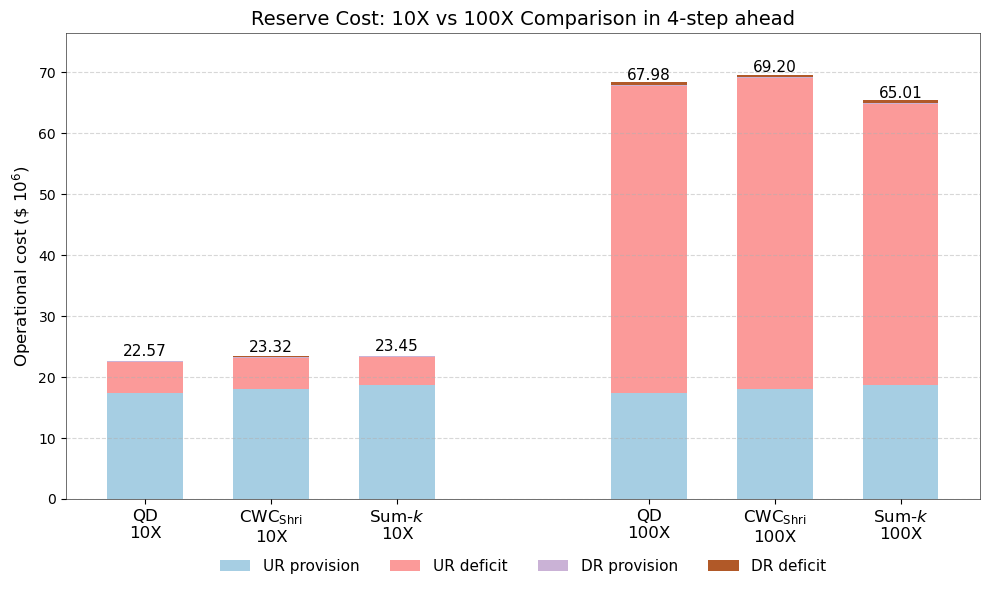

In [9]:
# Get the cost array shapes (assuming already loaded)
step_ahead = 4
cost_array_total_allcase = np.stack([cost_array_total_10x, cost_array_total_100x], axis = 5)
cost_evaluation = cost_array_total_allcase[:, :, step_ahead - 1, :, :, :]

formname = ['QD', r'$\mathrm{CWC}_{\mathrm{Shri}}$', r'Sum-$k$']
costname = ['UR provision', 'UR deficit', 'DR provision', 'DR deficit']
groupname = ['10x', '100x']
colors = plt.cm.Paired(np.linspace(0, 1, len(costname)))

# === Grouping Setup ===
n_methods = len(formname)
n_costs = len(costname)
n_group = len(groupname)

# Axis based on dimensionality
fig, ax = plt.subplots(figsize=(10, 6))

# Reduce dimensions to 3D: shape = (n_costs, n_methods, 2 cases (10x, 100x))
data = np.sum(cost_evaluation, axis = (0, 2)) / 1_000_000

x_ticks_collect = []

# Formatting
ymax = np.max(np.sum(data, axis=0))

for k in range(n_group):
    # Plot stacked bars for 10x group
    x = np.arange(n_methods) + n_methods*(k > 0) + k
    for i in range(n_costs):
        bottom = np.sum(data[:i, :, k], axis=0)
        ax.bar(x, data[i,:,k], bottom=bottom, width=0.6, color=colors[i], linewidth=1,
               label=costname[i])
    
    x_ticks_collect.append(x)
    
    # Add total value on top of each stacked bar
    for xi, total in zip(x, bottom):
        ax.text(
            xi,
            total + ymax * 0.005,  # safe offset
            f'{total:.2f}',
            ha='center', va='bottom',
            fontsize=11
        )
    if k == 0:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, fontsize=11, frameon=False)


# X-axis labels
xticks = np.concatenate(x_ticks_collect)
xtick_labels = [f'{name}\n10X' for name in formname] + [f'{name}\n100X' for name in formname]

ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, fontsize=12)

# Labels, title, legend
ax.set_ylim(0, ymax * 1.1) 
ax.set_ylabel(r'Operational cost (\$ $10^{6}$)', fontsize=12)
ax.set_title(f'Reserve Cost: 10X vs 100X Comparison in {step_ahead}-step ahead', fontsize=14)

# Aesthetics
ax.grid(True, axis='y', linestyle='--', alpha=0.5)
for spine in ax.spines.values():
    spine.set_linewidth(0.4)
    

plt.tight_layout()
plt.show()

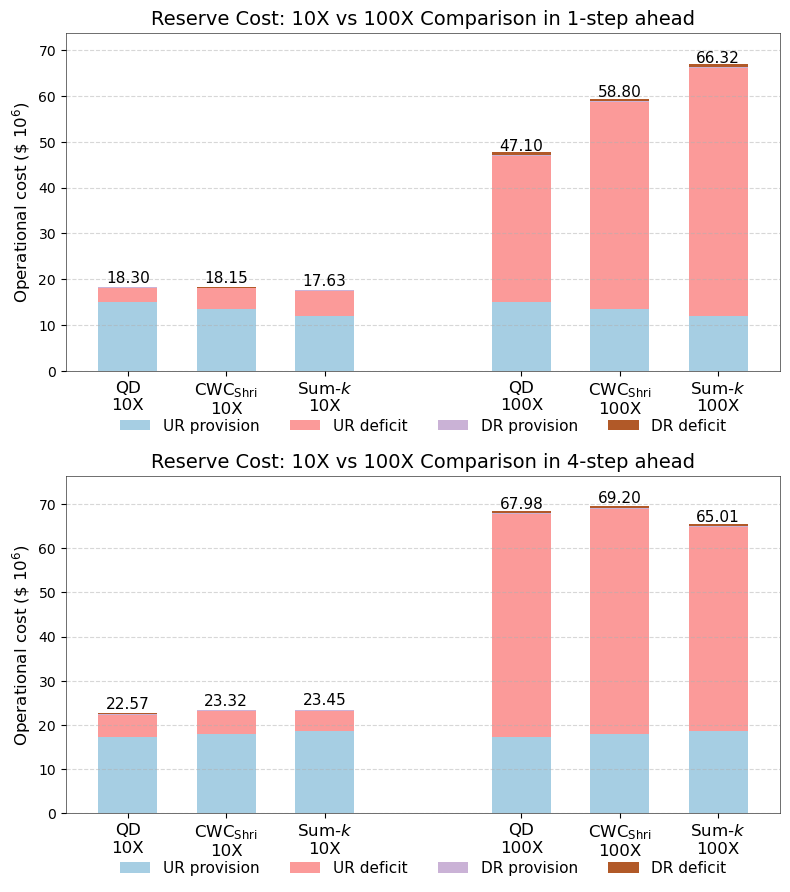

In [12]:
# Get the cost array shapes (assuming already loaded)
step_ahead_list = [1, 4]


formname = ['QD', r'$\mathrm{CWC}_{\mathrm{Shri}}$', r'Sum-$k$']
costname = ['UR provision', 'UR deficit', 'DR provision', 'DR deficit']
groupname = ['10x', '100x']
colors = plt.cm.Paired(np.linspace(0, 1, len(costname)))

# === Grouping Setup ===
n_methods = len(formname)
n_costs = len(costname)
n_group = len(groupname)

# Axis based on dimensionality
fig, ax = plt.subplots(nrows = len(step_ahead_list), figsize=(8, 4.5*(len(step_ahead_list))))

for step_idx, step_ahead in enumerate(step_ahead_list):
    cost_array_total_allcase = np.stack([cost_array_total_10x, cost_array_total_100x], axis = 5)
    cost_evaluation = cost_array_total_allcase[:, :, step_ahead - 1, :, :, :]
    # Reduce dimensions to 3D: shape = (n_costs, n_methods, 2 cases (10x, 100x))
    data = np.sum(cost_evaluation, axis = (0, 2)) / 1_000_000

    x_ticks_collect = []

    # Formatting
    ymax = np.max(np.sum(data, axis=0))

    for k in range(n_group):
        # Plot stacked bars for 10x group
        x = np.arange(n_methods) + n_methods*(k > 0) + k
        for i in range(n_costs):
            bottom = np.sum(data[:i, :, k], axis=0)
            ax[step_idx].bar(x, data[i,:,k], bottom=bottom, width=0.6, color=colors[i], linewidth=1,
                   label=costname[i])

        x_ticks_collect.append(x)

        # Add total value on top of each stacked bar
        for xi, total in zip(x, bottom):
            ax[step_idx].text(
                xi,
                total + ymax * 0.005,  # safe offset
                f'{total:.2f}',
                ha='center', va='bottom',
                fontsize=11
            )
        if k == 0:
            ax[step_idx].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, fontsize=11, frameon=False)


    # X-axis labels
    xticks = np.concatenate(x_ticks_collect)
    xtick_labels = [f'{name}\n10X' for name in formname] + [f'{name}\n100X' for name in formname]

    ax[step_idx].set_xticks(xticks)
    ax[step_idx].set_xticklabels(xtick_labels, fontsize=12)

    # Labels, title, legend
    ax[step_idx].set_ylim(0, ymax * 1.1) 
    ax[step_idx].set_ylabel(r'Operational cost (\$ $10^{6}$)', fontsize=12)
    ax[step_idx].set_title(f'Reserve Cost: 10X vs 100X Comparison in {step_ahead}-step ahead', fontsize=14)

    # Aesthetics
    ax[step_idx].grid(True, axis='y', linestyle='--', alpha=0.5)
    for spine in ax[step_idx].spines.values():
        spine.set_linewidth(0.4)


plt.tight_layout()
plt.show()

## Plotting stack bar

### Case 10x

#### Plot all cost

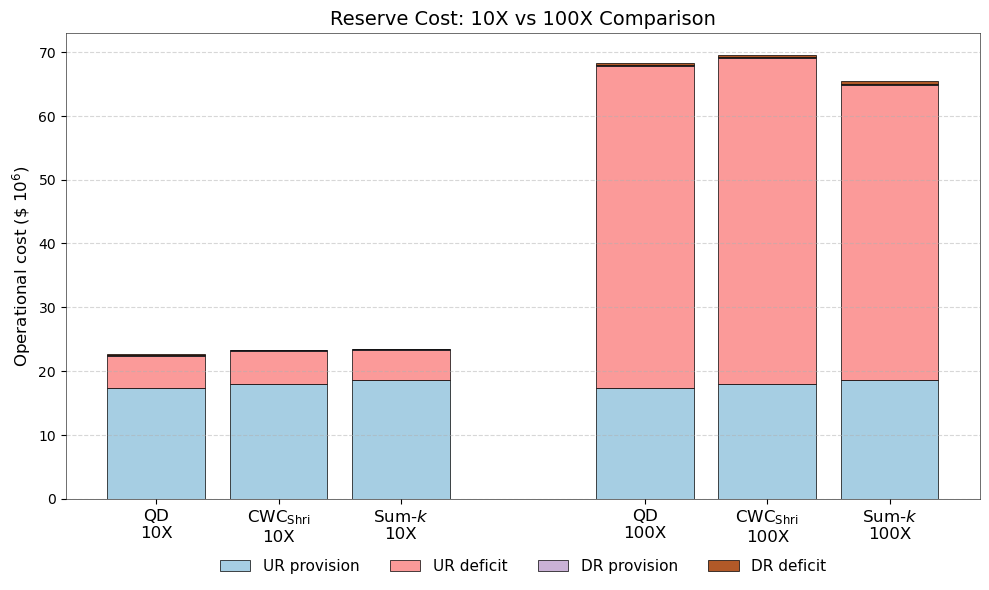

In [370]:
# # Get the cost array shapes (assuming already loaded)
# step_ahead = 4
# cost_evaluation_1 = cost_array_total_10x[:, :, step_ahead - 1, :, :]
# cost_evaluation_2 = cost_array_total_100x[:, :, step_ahead - 1, :, :]

# # Axis based on dimensionality
# sample_eval = cost_evaluation_1
# if len(sample_eval.shape) == 5:
#     axis = (0, 2, 3)
# elif len(sample_eval.shape) == 4:
#     axis = (0, 2)
# elif len(sample_eval.shape) == 3:
#     axis = (0,)
# else:
#     raise ValueError("Unsupported shape")

# # Reduce dimensions to 2D: shape = (n_costs, n_methods)
# data1 = np.sum(cost_evaluation_1, axis=axis) / 1_000_000
# data2 = np.sum(cost_evaluation_2, axis=axis) / 1_000_000

# formname = ['QD', r'$\mathrm{CWC}_{\mathrm{Shri}}$', r'Sum-$k$']
# costname = ['UR provision', 'UR deficit', 'DR provision', 'DR deficit']
# colors = plt.cm.Paired(np.linspace(0, 1, len(costname)))

# # === Grouping Setup ===
# n_methods = len(formname)
# n_costs = len(costname)

# x_10x = np.arange(n_methods)
# x_100x = x_10x + n_methods + 1  # Add spacing between groups

# fig, ax = plt.subplots(figsize=(10, 6))

# # Plot stacked bars for 10x group
# for i in range(n_costs):
#     bottom = np.sum(data1[:i, :], axis=0)
#     ax.bar(x_10x, data1[i], bottom=bottom, width=0.8, color=colors[i], edgecolor='black', linewidth=0.5,
#            label=costname[i])

# # Plot stacked bars for 100x group
# for i in range(n_costs):
#     bottom = np.sum(data2[:i, :], axis=0)
#     ax.bar(x_100x, data2[i], bottom=bottom, width=0.8, color=colors[i], edgecolor='black', linewidth=0.5)
    


# # X-axis labels
# xticks = np.concatenate([x_10x, x_100x])
# xtick_labels = [f'{name}\n10X' for name in formname] + [f'{name}\n100X' for name in formname]

# ax.set_xticks(xticks)
# ax.set_xticklabels(xtick_labels, fontsize=12)

# # Labels, title, legend
# ax.set_ylabel(r'Operational cost (\$ $10^{6}$)', fontsize=12)
# ax.set_title('Reserve Cost: 10X vs 100X Comparison', fontsize=14)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, fontsize=11, frameon=False)

# # Aesthetics
# ax.grid(True, axis='y', linestyle='--', alpha=0.5)
# for spine in ax.spines.values():
#     spine.set_linewidth(0.4)

# plt.tight_layout()
# plt.show()


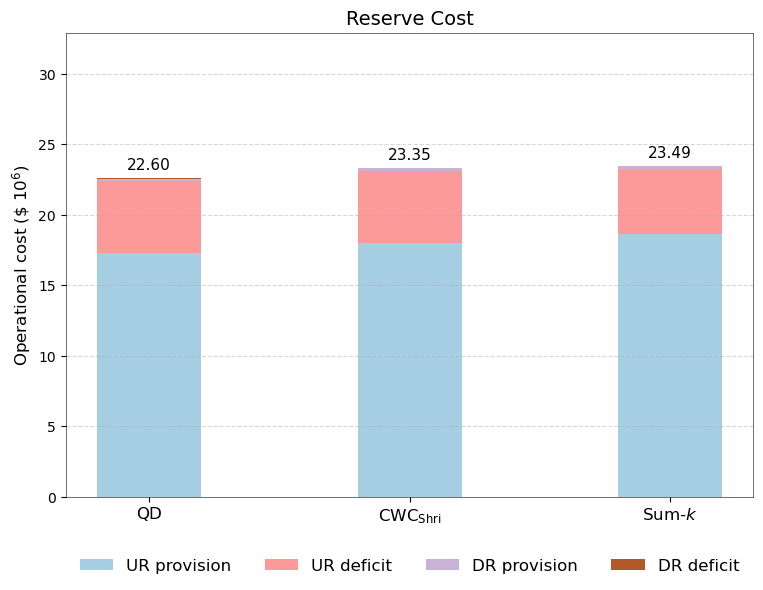

In [366]:
# # # (N, num_cost, num_step_ahead, (clearsky, partlycloudy, cloudy), num_methods)
# step_ahead = 4
# cost_evaluation_1 = cost_array_total_10x[:, :, step_ahead - 1, :, :]
# cost_evaluation_2 = cost_array_total_100x[:, :, step_ahead - 1, :, :]

# if len(cost_evaluation.shape) == 5:
#     axis = (0, 2, 3)
# elif len(cost_evaluation.shape) == 4:
#     axis = (0, 2)
# elif len(cost_evaluation.shape) == 3:
#     axis = (0)
# else:
#     raise ValueError("Unsupported length for the data")
# cost_methods_2d_array = np.sum(cost_evaluation, axis = axis)/ 1_000_000

# formname = ['QD', r'$\mathrm{CWC}_{\mathrm{Shri}}$', r'Sum-$k$']
# costname = ['UR provision', 'UR deficit', 'DR provision', 'DR deficit']

# data = cost_methods_2d_array
# n_groups, n_categories = data.shape
# x = np.arange(n_categories)
# bottom = np.zeros(n_categories)

# # Create figure and axis
# fig, ax = plt.subplots(figsize=(8, 6))

# # Plot stacked bars
# bar_width = 0.4
# colors = plt.cm.Paired(np.linspace(0, 1, n_groups))  # Optional color map
# for i in range(n_groups):
#     bars = ax.bar(
#         x ,  # Adjust position to reduce space
#         data[i],
#         bottom=bottom,
#         label=costname[i],
#         color=colors[i],
#         width=bar_width,
#         linewidth = 0.8
#     )
#     bottom += data[i]
    
# # Formatting
# ymax = np.max(np.sum(data, axis=0))

# # Add total value on top of each stacked bar
# for xi, total in zip(x, bottom):
#     ax.text(
#         xi,
#         total + ymax * 0.015,  # safe offset
#         f'{total:.2f}',
#         ha='center', va='bottom',
#         fontsize=11
#     )

# ax.set_ylim(0, ymax * 1.4) 
# ax.set_xticks(x)
# ax.set_xticklabels(formname, fontsize = 12)
# ax.set_ylabel(r'Operational cost (\$ $10^{6}$)', fontsize=12)
# # ax.set_xlabel('Method', fontsize = 12)

# ax.set_title('Reserve Cost', fontsize=14)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol =  4, fontsize=12, frameon = False)
# ax.grid(True, axis='y', linestyle='--', alpha=0.5)

# # Reduce the border line thickness
# for spine in ax.spines.values():
#     spine.set_linewidth(0.4)

# # Clean layout
# plt.tight_layout()
# plt.show()
# # report_savefig('10x_reserve_cost', resultfolderpath = figurefolderpath)

#### Plot cost for each sky condition

In [359]:
# step_ahead = 4
# cost_evaluation = cost_array_total_10x[:, :, step_ahead - 1, :, :]

# # Convert cost in the unit of $(x10^6)
# cost_methods_array = np.sum(cost_evaluation, axis=0) / 1_000_000

# formname = ['QD', r'$\mathrm{CWC}_{\mathrm{Shri}}$', r'Sum-$k$']
# costname = ['UR provision', 'DR provision', 'UR deficit', 'DR deficit']
# skycond_name = ['Clear-sky Condition', 'Partly Cloudy Condition', 'Cloudy Condition']

# fig, ax = plt.subplots(ncols=len(skycond_name), figsize=(16, 6))
# axes = ax.flatten()

# n_cost = len(costname)
# n_methods = len(formname)

# # Calculate global ymax for consistent label placement
# ymax_allskycond = np.max(np.sum(cost_methods_array, axis=0), axis=1)
# ymax = np.max(ymax_allskycond)

# bar_width = 0.4
# colors = plt.cm.Paired(np.linspace(0, 1, n_cost))

# for j, ax in enumerate(axes):
#     data_eachsky = cost_methods_array[:, j, :]
#     x = np.arange(n_methods)
#     bottom = np.zeros(n_methods)
    
#     for i in range(n_cost):
#         bars = ax.bar(
#             x,
#             data_eachsky[i],
#             bottom=bottom,
#             label=costname[i],
#             color=colors[i],
#             width=bar_width,
#             edgecolor='black',
#             linewidth=0.8
#         )
#         bottom += data_eachsky[i]

#     # Add total value on top of each stacked bar
#     for xi, total in zip(x, bottom):
#         ax.text(
#             xi,
#             total + ymax * 0.015,  # safe offset
#             f'{total:.2f}',
#             ha='center', va='bottom',
#             fontsize=11
#         )

#     ax.set_ylim(0, ymax * 1.15)
#     ax.set_xticks(x)
#     ax.set_xticklabels(formname, fontsize=12)
#     ax.set_ylabel(r'Operational cost (\$ $10^{6}$)', fontsize=12)
#     ax.set_title(f'{skycond_name[j]}', fontsize=14)

#     if j == 1:
#         ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=12, frameon=False)

#     ax.grid(True, axis='y', linestyle='--', alpha=0.5)

#     for spine in ax.spines.values():
#         spine.set_linewidth(0.4)

# plt.tight_layout()
# plt.subplots_adjust(wspace=0.2, bottom=0.25)
# plt.show()
# # report_savefig('10x_reserve_eachsky_cost', resultfolderpath = figurefolderpath)

### Case 100x

#### Plot all cost

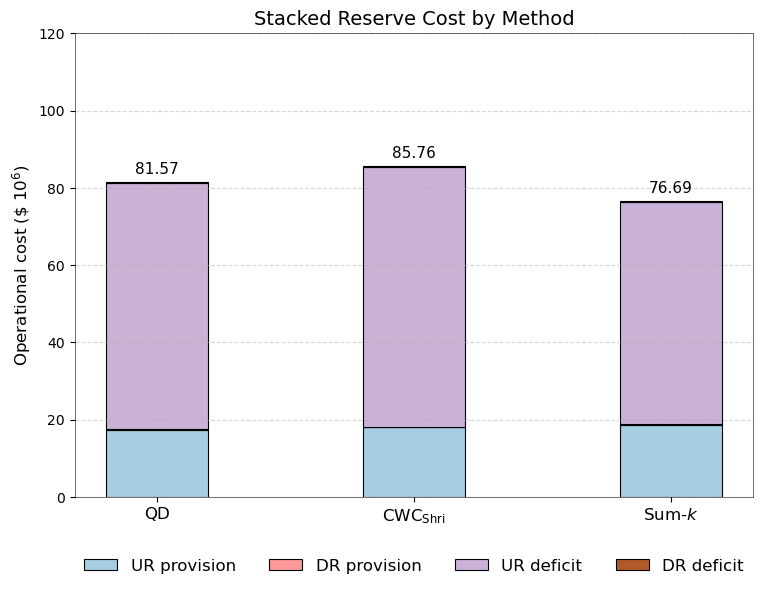

In [345]:
# # # (N, num_cost, num_step_ahead, (clearsky, partlycloudy, cloudy), num_methods)
# step_ahead = 4
# cost_evaluation = cost_array_total_100x[:, :, step_ahead - 1, :, :]

# if len(cost_evaluation.shape) == 5:
#     axis = (0, 2, 3)
# elif len(cost_evaluation.shape) == 4:
#     axis = (0, 2)
# elif len(cost_evaluation.shape) == 3:
#     axis = (0)
# else:
#     raise ValueError("Unsupported length for the data")
# cost_methods_2d_array = np.sum(cost_evaluation, axis = axis) / 1_000_000

# formname = ['QD', r'$\mathrm{CWC}_{\mathrm{Shri}}$', r'Sum-$k$']
# costname = ['UR provision', 'DR provision', 'UR deficit', 'DR deficit']

# data = cost_methods_2d_array
# n_groups, n_categories = data.shape
# x = np.arange(n_categories)
# bottom = np.zeros(n_categories)

# # Create figure and axis
# fig, ax = plt.subplots(figsize=(8, 6))

# # Plot stacked bars
# bar_width = 0.4
# colors = plt.cm.Paired(np.linspace(0, 1, n_groups))  # Optional color map
# for i in range(n_groups):
#     bars = ax.bar(
#         x ,  # Adjust position to reduce space
#         data[i],
#         bottom=bottom,
#         label=costname[i],
#         color=colors[i],
#         width=bar_width,
#         edgecolor='black',
#         linewidth = 0.8
#     )
#     bottom += data[i]

    
# # Formatting
# ymax = np.max(np.sum(data, axis=0))

# # Add total value on top of each stacked bar
# for xi, total in zip(x, bottom):
#     ax.text(
#         xi,
#         total + ymax * 0.015,  # safe offset
#         f'{total:.2f}',
#         ha='center', va='bottom',
#         fontsize=11
#     )

# ax.set_ylim(0, ymax * 1.4) 
# ax.set_xticks(x)
# ax.set_xticklabels(formname, fontsize = 12)
# ax.set_ylabel(r'Operational cost (\$ $10^{6}$)', fontsize=12)
# # ax.set_xlabel('Method', fontsize = 12)

# ax.set_title('Stacked Reserve Cost by Method', fontsize=14)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol =  4, fontsize=12, frameon = False)
# ax.grid(True, axis='y', linestyle='--', alpha=0.5)

# # Reduce the border line thickness
# for spine in ax.spines.values():
#     spine.set_linewidth(0.4)

# # Clean layout
# plt.tight_layout()
# plt.show()
# report_savefig('100x_reserve_cost', resultfolderpath = figurefolderpath)

#### Plot cost for each sky condition

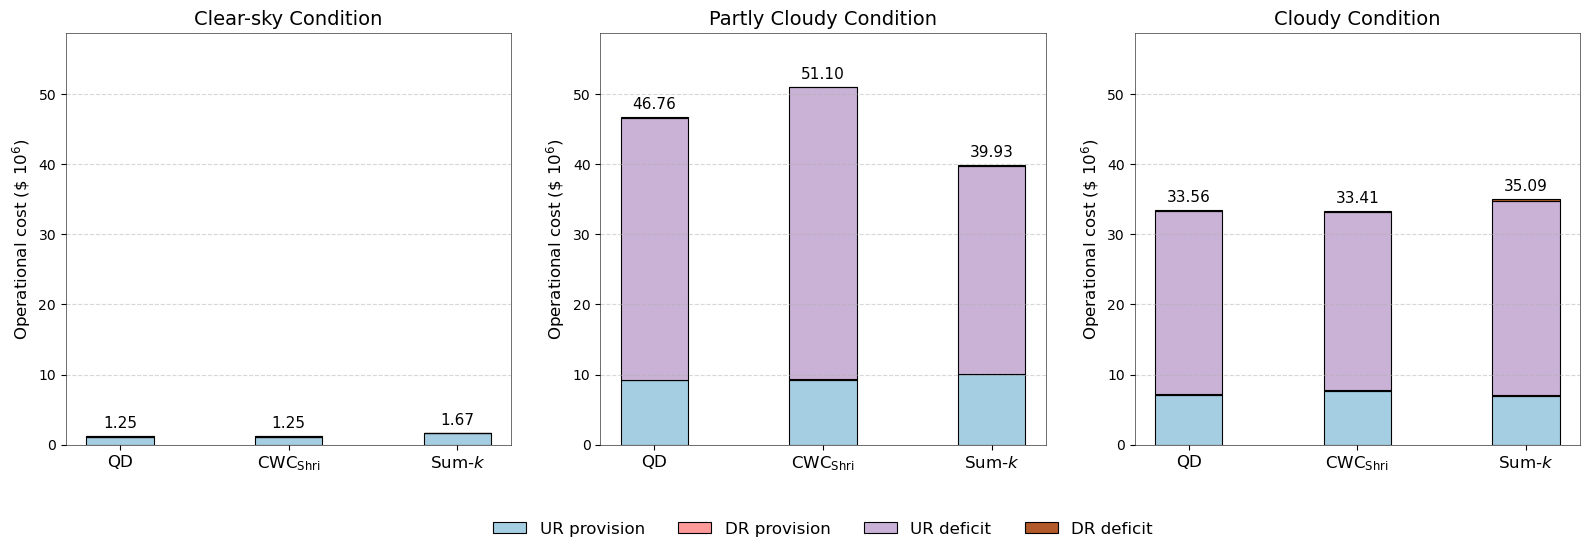

In [346]:
# step_ahead = 4
# cost_evaluation = cost_array_total_100x[:, :, step_ahead - 1, :, :]

# # Convert cost in the unit of $(x10^6)
# cost_methods_array = np.sum(cost_evaluation, axis=0) / 1_000_000

# formname = ['QD', r'$\mathrm{CWC}_{\mathrm{Shri}}$', r'Sum-$k$']
# costname = ['UR provision', 'DR provision', 'UR deficit', 'DR deficit']
# skycond_name = ['Clear-sky Condition', 'Partly Cloudy Condition', 'Cloudy Condition']

# fig, ax = plt.subplots(ncols=len(skycond_name), figsize=(16, 6))
# axes = ax.flatten()

# n_cost = len(costname)
# n_methods = len(formname)

# # Calculate global ymax for consistent label placement
# ymax_allskycond = np.max(np.sum(cost_methods_array, axis=0), axis=1)
# ymax = np.max(ymax_allskycond)

# bar_width = 0.4
# colors = plt.cm.Paired(np.linspace(0, 1, n_cost))

# for j, ax in enumerate(axes):
#     data_eachsky = cost_methods_array[:, j, :]
#     x = np.arange(n_methods)
#     bottom = np.zeros(n_methods)
    
#     for i in range(n_cost):
#         bars = ax.bar(
#             x,
#             data_eachsky[i],
#             bottom=bottom,
#             label=costname[i],
#             color=colors[i],
#             width=bar_width,
#             edgecolor='black',
#             linewidth=0.8
#         )
#         bottom += data_eachsky[i]

#     # Add total value on top of each stacked bar
#     for xi, total in zip(x, bottom):
#         ax.text(
#             xi,
#             total + ymax * 0.015,  # safe offset
#             f'{total:.2f}',
#             ha='center', va='bottom',
#             fontsize=11
#         )

#     ax.set_ylim(0, ymax * 1.15)
#     ax.set_xticks(x)
#     ax.set_xticklabels(formname, fontsize=12)
#     ax.set_ylabel(r'Operational cost (\$ $10^{6}$)', fontsize=12)
#     ax.set_title(f'{skycond_name[j]}', fontsize=14)

#     if j == 1:
#         ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=12, frameon=False)

#     ax.grid(True, axis='y', linestyle='--', alpha=0.5)

#     for spine in ax.spines.values():
#         spine.set_linewidth(0.4)

# plt.tight_layout()
# plt.subplots_adjust(wspace=0.2, bottom=0.25)
# plt.show()
# report_savefig('100x_reserve_eachsky_cost', resultfolderpath = figurefolderpath)

## Plotting timeseries

In [141]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'notebook_connected'  # or 'notebook'

fig = go.Figure()
step_ahead = 1
method_index = 0
y_plot = y_site[:, step_ahead - 1, method_index] # All method_index are the same
y_pred = y_pred_site[:, step_ahead - 1, method_index]

# Extract intervals for each method
pi_plot_qd = pi_site[:, 2 * (step_ahead - 1): 2 * (step_ahead), 0]
pi_plot_cwc = pi_site[:, 2 * (step_ahead - 1): 2 * (step_ahead), 1]
pi_plot_sumk = pi_site[:, 2 * (step_ahead - 1): 2 * (step_ahead), 2]

x = np.arange(len(y_plot))

# Ground truth
fig.add_trace(go.Scatter(
    x=x,
    y=y_plot,
    mode='lines',
    name='Ground Truth',
    line=dict(color='black')
))

# Ground truth
fig.add_trace(go.Scatter(
    x=x,
    y=y_pred,
    mode='lines',
    name='Point forecast',
    line=dict(color='#1f77b4', dash='dash')
))

# Function to add PI bands
def add_pi_band(fig, x, pi, name, fillcolor):
    fig.add_trace(go.Scatter(
        x=x,
        y=pi[:, 1],
        mode='lines',
        line=dict(width=0),
        showlegend=False
    ))
    fig.add_trace(go.Scatter(
        x=x,
        y=pi[:, 0],
        mode='lines',
        fill='tonexty',
        fillcolor=fillcolor,
        line=dict(width=0),
        name=name
    ))

# Add PIs with distinguishable colors
add_pi_band(fig, x, pi_plot_sumk, 'Sumk PI', 'rgba(0, 0, 255, 0.3)')   # blue
add_pi_band(fig, x, pi_plot_qd, 'QD PI', 'rgba(255, 0, 0, 0.3)')       # red
add_pi_band(fig, x, pi_plot_cwc, 'CWC PI', 'rgba(0, 128, 0, 0.3)')     # green

fig.update_layout(
    title=f'Prediction Intervals for Step Ahead {step_ahead}',
    xaxis_title='Time Index',
    yaxis_title='Value',
    template='plotly_white'
)

fig.show()